# Plant Sciences 2022 - Scanpy Tutorial

**Tips:**

    - select a cell and shift-Enter to execute it
    - Remember to execute cells in order!
    - If you run a cell and you get an error message about something not being defined, you probably ran things out of order

In [1]:
import pandas as pd
import os, glob, sys
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
import scipy

import scanpy as sc
import gtfparse
import scrublet as scr

from IPython.display import Image
from IPython.core.display import HTML 

#Set some default figure parameters
sc.settings.set_figure_params(dpi=80, color_map="Reds", figsize=[4,4])

#Scanpy verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3

# Print which versions of the dependencies we are running
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


<img align="left" src="https://scanpy.readthedocs.io/en/stable/_static/Scanpy_Logo_BrightFG.svg" width=400 />  

This tutorial will make heavy use of "Scanpy" single-cell analysis package for Python.  
https://scanpy.readthedocs.io/en/stable/

# Download the Course Data

There should be a folder called 'data/' in this directory containing the Cellranger outputs from your samples collected in the lab.

In [2]:
# check to make sure you see the 'data' folder
os.listdir()

['.local',
 'FTPS22_data.tar.gz',
 'environment.yml',
 'miniconda3',
 'data',
 '.ipython',
 'birnbaum',
 'FTPS22_processed.h5ad',
 '._birnbaum',
 '.bashrc',
 'nohup.out',
 '.ssh',
 '.ipynb_checkpoints',
 '.conda',
 '.wget-hsts',
 '._data',
 '.jupyter',
 '.profile',
 '.lesshst',
 '.python_history',
 '.bash_history',
 '.config',
 'FTPS_data_viewer.ipynb',
 'FTPS22_Data_Exploration.ipynb',
 '.cache',
 '.bash_logout']

In [4]:
# check the contents of the 'data' folder. 
# There are a couple of ways to view the contents of folders in Python.
# Note that using 'os', we saw some ugly hidden files (eg, '._data') carried over from my Mac
# 'glob' is another usful module, mainly for grabbing multiple files at a time... in a glob
# glob natively ignores ugly hidden file types, 

glob.glob('*')

['environment.yml',
 'miniconda3',
 'data',
 'FTPS22_processed.h5ad',
 'nohup.out',
 'FTPS_data_viewer.ipynb',
 'FTPS22_Data_Exploration.ipynb']

In [5]:
# What is in the data folder?
glob.glob('data/*')

['data/logs',
 'data/aggr',
 'data/Untitled.ipynb',
 'data/aggr.csv',
 'data/count',
 'data/scripts',
 'data/_runids',
 'data/qsub.command',
 'data/genes.gtf.gz',
 'data/SampleSheet.csv']

In [3]:
# Our Cellranger results for each sample separately are stored under 'data/count'
path = 'data/count/'
glob.glob(path + '*')

['data/count/FTPS22_Treat',
 'data/count/combined_metrics_summaries.csv',
 'data/count/FTPS22_Ctrl',
 'data/count/summary_stats.csv']

In [4]:
# Oh look! Somebody nicely made a csv file that summarizes the key QC metrics of the two samples.
# Read it in using Pandas.  For viewability, I'll transpose it to vertical format by calling '.T'
summ = pd.read_csv(path + 'combined_metrics_summaries.csv', index_col=0).T
summ

Sample                                          FTPS22_Ctrl FTPS22_Treat
Estimated Number of Cells                             4,399        1,005
Mean Reads per Cell                                 129,481      579,429
Median Genes per Cell                                 3,643        1,131
Number of Reads                                 569,587,142  582,326,585
Valid Barcodes                                        93.9%        90.6%
Sequencing Saturation                                 55.0%        72.3%
Q30 Bases in Barcode                                  96.6%        96.4%
Q30 Bases in RNA Read                                 96.3%        96.2%
Q30 Bases in UMI                                      96.6%        96.3%
Reads Mapped to Genome                                64.5%        28.2%
Reads Mapped Confidently to Genome                    58.7%        16.4%
Reads Mapped Confidently to Intergenic Regions         4.4%         2.7%
Reads Mapped Confidently to Intronic Regions           0.6%         0.2%
Reads Mapped Confidently to Exonic Regions            53.7%        13.5%
Reads Mapped Confidently to Transcriptome             51.2%        12.8%
Reads Mapped Antisense to Gene                         0.5%         0.1%
Fraction Reads in Cells                               93.8%        86.1%
Total Genes Detected                                 28,894       25,431
Median UMI Counts per Cell                           13,795        1,982

In [11]:
glob.glob('data/aggr/FTPS22/outs/count/*')

['data/aggr/FTPS22/outs/count/summary.json',
 'data/aggr/FTPS22/outs/count/cloupe.cloupe',
 'data/aggr/FTPS22/outs/count/filtered_feature_bc_matrix',
 'data/aggr/FTPS22/outs/count/raw_feature_bc_matrix.h5',
 'data/aggr/FTPS22/outs/count/analysis',
 'data/aggr/FTPS22/outs/count/filtered_feature_bc_matrix.h5']

## Import the filtered gene expression matrix

Cellranger outputs its matrix in two formats: **MTX** and **HDF5**

**MTX** formatted data must come as a bundle of 3 files:

    - the actual matrix (matrix.mtx.gz). Basically just a long string of numbers in a sparse format.
    - the list of barcodes (barcodes.tsv.gz)
    - the list of gene/feature names (features.tsv.gz)
    
**HDF5** is a container format that packages all this and more. 

In [12]:
def concat_h5_GEX(list_of_h5s, join='outer'):
    """
    Feed in a list of paths to .hdf5-format Cellranger matrix files
    Returns: Scanpy (AnnData) object with all samples concatenated
    """
    merged_uns = {}
    
    for n,h5 in enumerate(list_of_h5s):
        tmp = sc.read_10x_h5(h5) # creates temporary scanpy object
        tmp.var_names_make_unique()
        LIBRARY_ID = h5s[n].split('/')[-3]
        tmp.obs.index = tmp.obs.index + '-' + LIBRARY_ID
        tmp.obs['Sample'] = LIBRARY_ID
        
        if n == 0:
            adata = tmp.copy()
        else:
            adata = adata.concatenate(tmp, 
            batch_key=None, 
            index_unique=None, 
            join=join,
            )
    adata.uns['Sample_Metadata'] = merged_uns
            
    return adata

In [16]:
h5s = glob.glob('data/count/*/outs/filt*h5')

h5s

['data/count/FTPS22_Treat/outs/filtered_feature_bc_matrix.h5',
 'data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5']

In [42]:
# Read in both data matrices to generate a new AnnData object with both samples
h5s = glob.glob('data/count/*/outs/filt*h5')
adata = concat_h5_GEX(h5s)

reading data/count/FTPS22_Treat/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [43]:
adata

AnnData object with n_obs × n_vars = 5404 × 39483
    obs: 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Sample_Metadata'

In [44]:
# Make sure we've got the right number of cells from each sample
adata.obs['Sample'].value_counts()

FTPS22_Ctrl     4399
FTPS22_Treat    1005
Name: Sample, dtype: int64

### Start annotating
**Firstly, let's stash the raw digital gene counts data in a layer called 'counts':**

As a refresher, this is the structure of the AnnData object at the core of your Scanpy project:

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg" width=400 />

AnnData objects by default store their core numerical data in an attribute called '.X'
When we first read in the matrix, 'adata.X' is populated with the raw counts, but as we preprocess and manipulate the data, this will be transformed. Best to stash the raw counts somewhere in case we want to access them again later.

Thankfully, AnnData has the ability to save arbitrarily many data matrices as 'layers', provided they have the same shape as the overall object (that is, it must be a full matrix that spans every gene and cell in the dataset)

In practice, layers can be used to store all kinds of transformations of the original data.  Normalizations, logarithmized versions, etc.  They are also often used to store spliced and non-spliced read counts, ie. for RNA velocity analysis.

In [19]:
# Let's look at what is currently stored in .X:
adata.X

<5404x39483 sparse matrix of type '<class 'numpy.float32'>'
	with 20063981 stored elements in Compressed Sparse Row format>

As you can see, adata.X is a sparse matrix. This is a memory-efficient type of numerical array that can be read and manipulated using Python's "SciPy" library, which is called in the background by Scanpy. You can also see that it is stored as a 32-bit floating-point number, which is a little odd considering these data are currently integer counts. It's not a big deal, but for memory and disk-space efficiency, you should sometimes think about whether the datatype being used to represent your data is the right choice.

In [45]:
# Let's stash the raw counts as integers.  
# Remember to call .copy() -- this ensures that the new thing being created isn't 
# just a passive pointer to the original data, but is in fact a completely separate new object.
adata.layers['counts'] = adata.X.astype('int').copy()

# Check that we have added the new layer:
print(adata.layers)

Layers with keys: counts


In [21]:
adata.layers['counts']

<5404x39483 sparse matrix of type '<class 'numpy.int64'>'
	with 20063981 stored elements in Compressed Sparse Row format>

## Cell-level metadata

Any per-cell annotation is stored in the **.obs** dataframe. This is a standard Pandas dataframe that can store cell type labels, numerical measures like UMI counts, sample metadata, or basically anything you might store in an Excel spreadsheet.

In [46]:
# Let's save a count of how many UMIs and unique genes are found in each cell:
# We will use Numpy for this simple math step
# The .A1 at the end reformats the data into a single 1-D flat array, rather than as a 1x5404 vertical stack.  
# This is a dumb annoying thing about how Numpy arrays work

adata.obs['n_counts'] = np.sum(adata.layers['counts'], axis=1).A1

# Let's also save a count of the number of unique genes found in each cell:
# This counts how many genes have a UMI count > 0
adata.obs['n_genes'] = np.sum(adata.layers['counts'] > 0, axis=1).A1

# For good measure, let's also sort the UMI counts in log space
adata.obs['log(UMIs)'] = np.log10(adata.obs['n_counts'])

In [47]:
# Let's see what that just added:
adata.obs[:5]

Sample  n_counts  n_genes  log(UMIs)
AAACGAAGTTGTAGCT-1-FTPS22_Treat  FTPS22_Treat       507      379   2.705008
AAACGCTTCCATCTGC-1-FTPS22_Treat  FTPS22_Treat    339576    15461   5.530937
AAACGCTTCTACGCGG-1-FTPS22_Treat  FTPS22_Treat      1872     1226   3.272306
AAAGAACCACTTTAGG-1-FTPS22_Treat  FTPS22_Treat     96279     9342   4.983532
AAAGAACTCGAGTGAG-1-FTPS22_Treat  FTPS22_Treat       631      155   2.800029

#### Organellar RNAs

In mammalian systems, it is useful to track potentially dead or low-quality cells by looking at the fraction of reads coming from the mitochondrial genome.  This is because when a cell is dying, the plasma membrane permeabilizes and releases cellular mRNAs in the the medium or exposes them to RNA degradation. Meanwhile, RNAs stuck in the mitochondria are protected until the bitter end.  

**How can we figure out which genes in our matrix are encoded by the mitochondrial or chloroplast genomes?**

Simple: let's look at the GTF file!  I conveniently included it in the 'data/' directory

In [24]:
gtffile = 'data/genes.gtf.gz'

# Read in the GTF file using the installed package 'gtfparse'.
# It doesn't do anything fancy except shortcut some annoying parsing steps via Pandas

gtf = gtfparse.read_gtf(gtffile)

# View the first few lines of the table
gtf[:3]

/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_name', 'gene_name']


seqname   source     feature  start   end  score strand frame  \
0       1  gramene        gene   4854  9652    NaN      -     0   
1       1  gramene  transcript   4854  9652    NaN      -     0   
2       1  gramene        exon   9193  9652    NaN      -     0   

         gene_id gene_version  ... transcript_version transcript_source  \
0  GRMZM2G059865            1  ...                                        
1  GRMZM2G059865            1  ...                  1           gramene   
2  GRMZM2G059865            1  ...                  1           gramene   

  transcript_biotype exon_number                  exon_id exon_version  \
0                                                                        
1     protein_coding                                                     
2     protein_coding           1  GRMZM2G059865_T01.exon1            1   

  protein_id protein_version transcript_name gene_name  
0                                                       
1                                                       
2                                                       

[3 rows x 23 columns]

In this GTF file, 'seqname' corresponds to the name of the chromosome or genomic scaffold housing the gene.  Let's see what the breakdown of these are in this annotation.  

In [25]:
# Use Pandas' built-in method for counting unique objects in a Series:
gtf['seqname'].value_counts()

1     154690
2     116523
5     116092
4     105580
3     104818
8      87780
6      82199
7      78476
9      75666
10     65579
Mt       836
Pt       357
Name: seqname, dtype: int64

Let's save a few of these gene annotation features into a new dataframe for later.  We will merge them into the Scanpy object in case we want to explore gene expression based on their chromosomal location, or average gene length, or strand, or some such thing

In [26]:
# Use the Pandas dataframe 'query' method to filter out only rows annotating genes
gene_anno = gtf.query(
    'feature == "gene"')\
    .set_index('gene_id')\
    .loc[:,['seqname','start','end','strand','frame','gene_name']]

gene_anno[:3]

seqname   start     end strand frame gene_name
gene_id                                                     
GRMZM2G059865       1    4854    9652      -     0          
GRMZM5G888250       1    9882   10387      -     0          
GRMZM2G093344       1  109519  111769      -     0

Note that many of these features are blank in their gene_name column (but not all of them).  Y'all need to name your genes, Maizefolks! When Cellranger is counting genes, it assigns a read to its corresponding mapped gene, and uses the gene_name column as the feature name, if available.  If not, it defaults to the gene_id column.  Thus, our gene names in our Cellranger data matrix are going to be a confusing mixture of entries from the gene_name column and the gene_id column.

In [30]:
# you can also slice a Pandas dataframe like this:

Mt_df = gene_anno[gene_anno['seqname'] == 'Mt'] # Mitochondrial genes
Pt_df = gene_anno[gene_anno['seqname'] == 'Pt'] # Chloroplast genes

Mt_df

seqname   start     end strand frame gene_name
gene_id                                                     
GRMZM5G816453      Mt    8752    9915      +     0          
GRMZM5G806435      Mt   11111   13315      -     0          
GRMZM5G853409      Mt   17207   19115      +     0          
GRMZM5G849223      Mt   19813   20889      +     0          
GRMZM5G892769      Mt   21090   22698      +     0          
...               ...     ...     ...    ...   ...       ...
GRMZM5G834282      Mt  548916  549248      +     0          
GRMZM5G893089      Mt  550608  550973      +     0          
GRMZM5G872234      Mt  564155  564517      -     0          
GRMZM5G836544      Mt  564497  564946      +     0          
GRMZM5G897755      Mt  565003  565665      +     0          

[123 rows x 6 columns]

In [31]:
# Note that a few of the mitochondrial genes have annotated gene names.  
# Thus, Cellranger will have used these as the gene name in the data matrix

Mt_df['gene_name'].value_counts()

           121
NDHB1        1
ycf72-2      1
Name: gene_name, dtype: int64

In [32]:
# Let's extract all the gene names in our AnnData object corresponding to these gene_ids:
# We will use the gene_ids column to match to this Mt dataframe
adata.var[:3]


gene_ids    feature_types               genome
GRMZM2G059865  GRMZM2G059865  Gene Expression  Zea_Mays_v3_Mar2019
GRMZM5G888250  GRMZM5G888250  Gene Expression  Zea_Mays_v3_Mar2019
GRMZM2G093344  GRMZM2G093344  Gene Expression  Zea_Mays_v3_Mar2019

In [33]:
# Do a logical test to see if each gene_id is in our Mt_df index:
matches_mito = adata.var['gene_ids'].isin(Mt_df.index)
matches_mito

GRMZM2G059865       False
GRMZM5G888250       False
GRMZM2G093344       False
GRMZM2G093399       False
GRMZM5G809743       False
                    ...  
GRMZM5G855343       False
GRMZM2G054501       False
AC191109.3_FG001    False
GRMZM2G372364       False
GRMZM2G525788       False
Name: gene_ids, Length: 39483, dtype: bool

In [34]:
# Now use this boolean vector to slice our adata.var_names to extract mitochondrial genes
Mt_genes = adata.var_names[matches_mito].tolist()
Mt_genes[:3]

['GRMZM5G816453', 'GRMZM5G806435', 'GRMZM5G853409']

In [35]:
# Repeat the same thing for chloroplast genes as a one-liner:
Pt_genes = adata.var_names[adata.var['gene_ids'].isin(Pt_df.index)].tolist()
Pt_genes[:3]

['MATK', 'RPS16', 'PSBC']

In [48]:
# Now, use these lists to compute the fraction of each transcriptome coming from that organelle:

adata.obs['frac_Mt'] = (np.sum(adata[:, Mt_genes].layers['counts'], axis=1)\
                        / np.sum(adata.layers['counts'], axis=1)).A1

adata.obs['frac_Pt'] = (np.sum(adata[:, Pt_genes].layers['counts'], axis=1) \
                        / np.sum(adata.layers['counts'], axis=1)).A1


... storing 'Sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


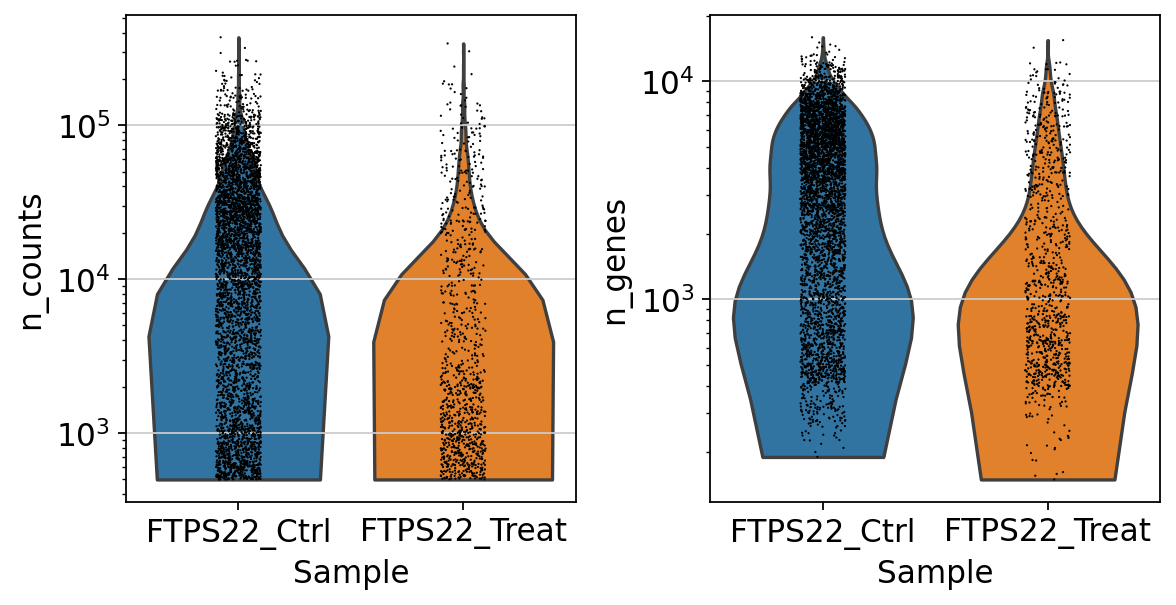

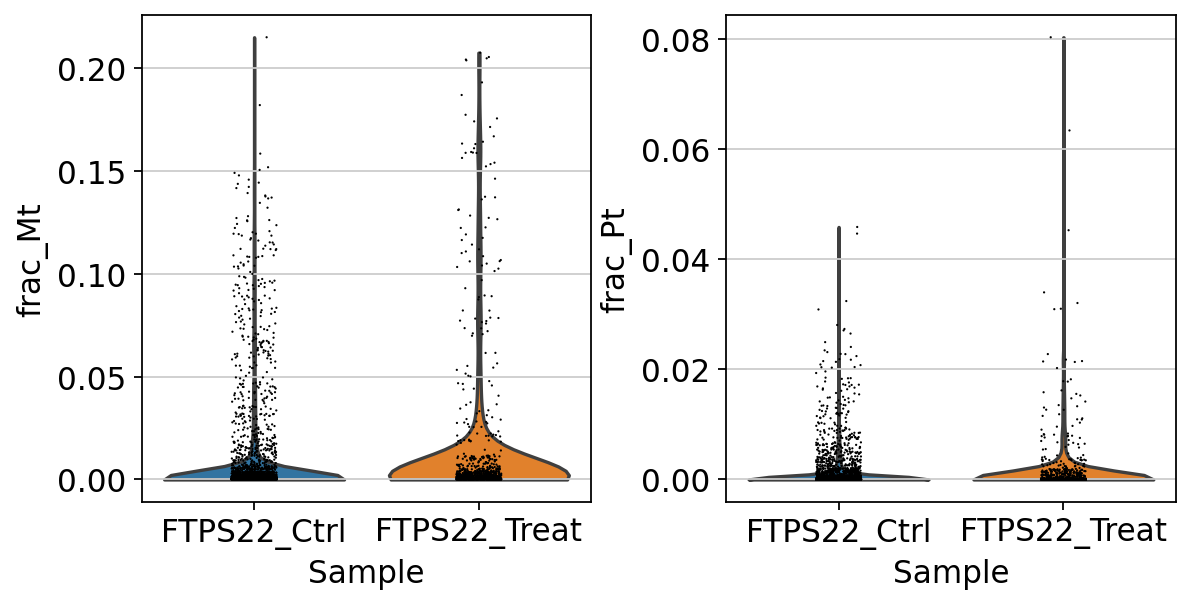

In [49]:
sc.pl.violin(adata, groupby='Sample', keys=['n_counts','n_genes'], log=True)
sc.pl.violin(adata, groupby='Sample', keys=['frac_Mt','frac_Pt'])

## Preprocessing and normalization

By default, Scanpy takes a very simple and straightforward approach to normalizing the gene expression levels across cells in the dataset:   

$$ normCounts = (gene XCounts\:/\: totalCounts)\: x \:10^4$$

This is a big topic, with a lot of opinions about whether you should use much fancier methods:   
https://blog.bioturing.com/2022/01/27/a-guide-to-scrna-seq-normalization/  
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1  
https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full

In [50]:
def preprocess(adata):
    sc.pp.normalize_total(
        adata, 
        target_sum=1e4, # "reads per 10k" is the norm for single-cell data, for some reason
        exclude_highly_expressed=True, #If any cell is dominated by a given gene, exclude those from computing the normalization factor
        max_fraction = 0.05)
    
    sc.pp.log1p(adata)
    
    # saves the log-normalized counts to a daughter object. 
    # This will be called under the hood by differential expression and plotting tools
    adata.raw = adata.copy()
    
    return adata

preprocess(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GRMZM2G314328', 'GRMZM2G157845', 'GRMZM2G411652', 'GRMZM2G146502', 'GRMZM2G019039', 'GRMZM2G099496', 'GRMZM2G097316', 'GRMZM2G097340', 'GRMZM2G144653', 'GRMZM2G329636', 'GRMZM2G066111', 'GRMZM2G442129', 'GRMZM2G391286', 'GRMZM5G834666', 'GRMZM2G054501']
    finished (0:00:00)


AnnData object with n_obs × n_vars = 5404 × 39483
    obs: 'Sample', 'n_counts', 'n_genes', 'log(UMIs)', 'frac_Mt', 'frac_Pt'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Sample_Metadata', 'Sample_colors', 'log1p'
    layers: 'counts'

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


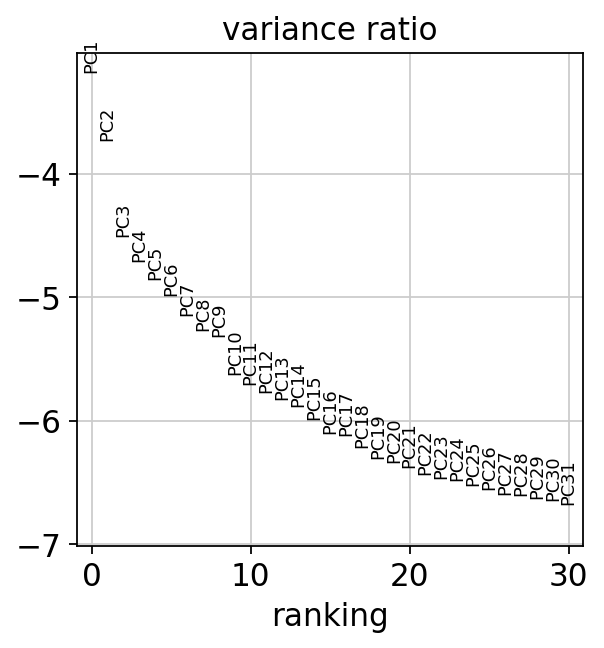

In [51]:
def reduce_dimensions(adata):
    sc.pp.scale(adata, max_value=10)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata, log=True)
    
reduce_dimensions(adata)

## Cluster cells
To identify cell clusters, we must first compute a neighbor graph. The first step of this is to compute all pairwise distances between cells in the dataset.  In the picture below, it is easy to imagine how to compute the distance between two points on the 2D plane.  For us, we are computing the graph in higher dimensions. Using all ~30k genes in the dataset would be crazy.  Instead, we are using the reduced dimension space we just computed via PCA to calculate these distances.  

The neighbor graph algorithm then figures out which cells are connected to which. Usually, the graph is pruned down to only the closest "K" nearest neighbors, hence the common name 'knn' graphs.  Scanpy uses a default of **knn=15**

The clustering algorithm uses a form of <a href="https://timoast.github.io/blog/community-detection/"> community detection via modularity optimization </a>. Basically, it tries to enclose communities of cells in bubbles, checks to see how many close neighbors got assigned to the same vs different bubbles, and then keeps tweaking those bubbles until it can't do any better at grouping like cells together.

<img src='https://miro.medium.com/max/738/1*skhjgApyDIPbJNolIZCF5w.png' width=300 align=left>

In [52]:

sc.pp.neighbors(
    adata,
    n_neighbors = 15, # default=15
    n_pcs = None, # Use all pre-computed PCs by default
    metric = 'euclidean' # there are lots of possible distance metrics.  Try 'cityblock' or 'cosine'
)

# Clustering by Leiden modularity optimization
sc.tl.leiden(
    adata, 
    resolution=0.5, # Try playing with this!
    key_added='Cluster' # This is the key that will appear in adata.obs with the new cluster names
    # You can repeat clustering again and again and give it a new key name each time, if you want
)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 15 clusters and added
    'Cluster', the cluster labels (adata.obs, categorical) (0:00:00)


## Nonlinear Dimensionality Reduction

PCA helped reduce our dimensionality from ~30,000 down to ~50, but unfortunately our computer screens only easily display 2 dimensions.  
**tSNE** and **UMAP** are two commonly used to bring the number of dimensions down to 2 for visualization purposes. Keep in mind that the non-linearity of these methods means they are generally not very useful analytical tools.  Again, they are for *visualization*.  

**Which to use?**
UMAP has become more standard because it tends to better preserve global relationship between cell types. That is, very different cell types stay far away from one another, while similar cells are kind of packed in amorphously.  tSNE prioritizes local structure, emphasizing 'sub-cluster-level' details. But scRNA-seq data is so noisy, that focusing on these minute details is probably a waste of time.

<a href='https://pair-code.github.io/understanding-umap/'> Here is a super fun interactive explanation of the differences between UMAP and tSNE </a>


In [55]:
# Compute tSNE projection
sc.tl.tsne(adata)

# Compute UMAP projection
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


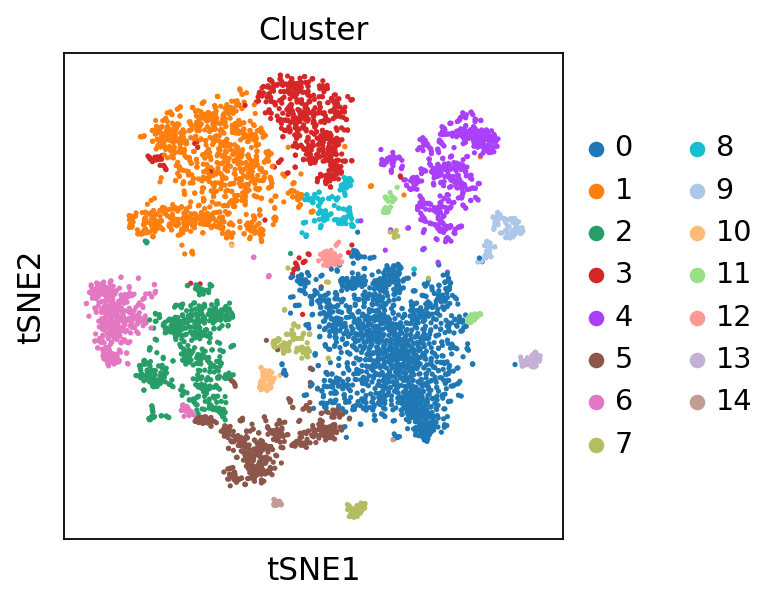

In [59]:
sc.pl.tsne(adata, color='Cluster')

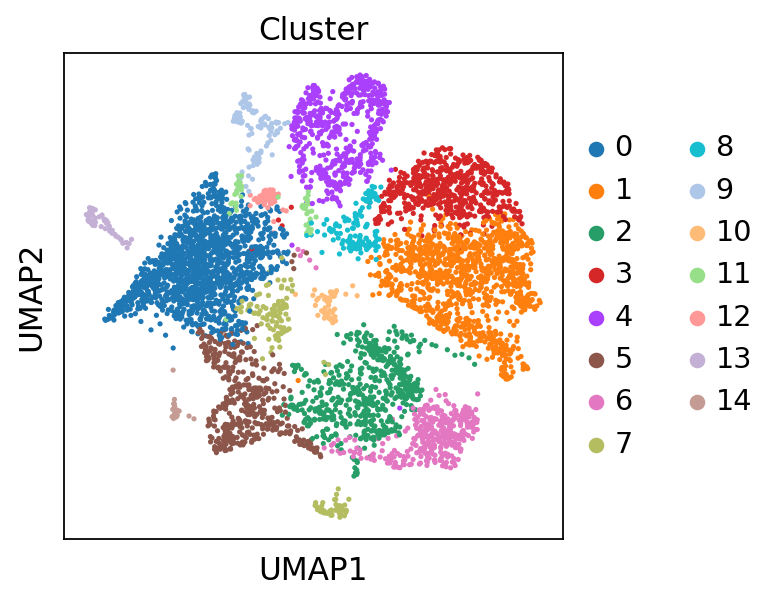

In [56]:
sc.pl.umap(adata, color='Cluster')

## Filter cells

Some of these cells probably should have never made the final cut.  Let's visualize all the cells with fewer than 1,000 UMIs:


... storing 'OK' as categorical


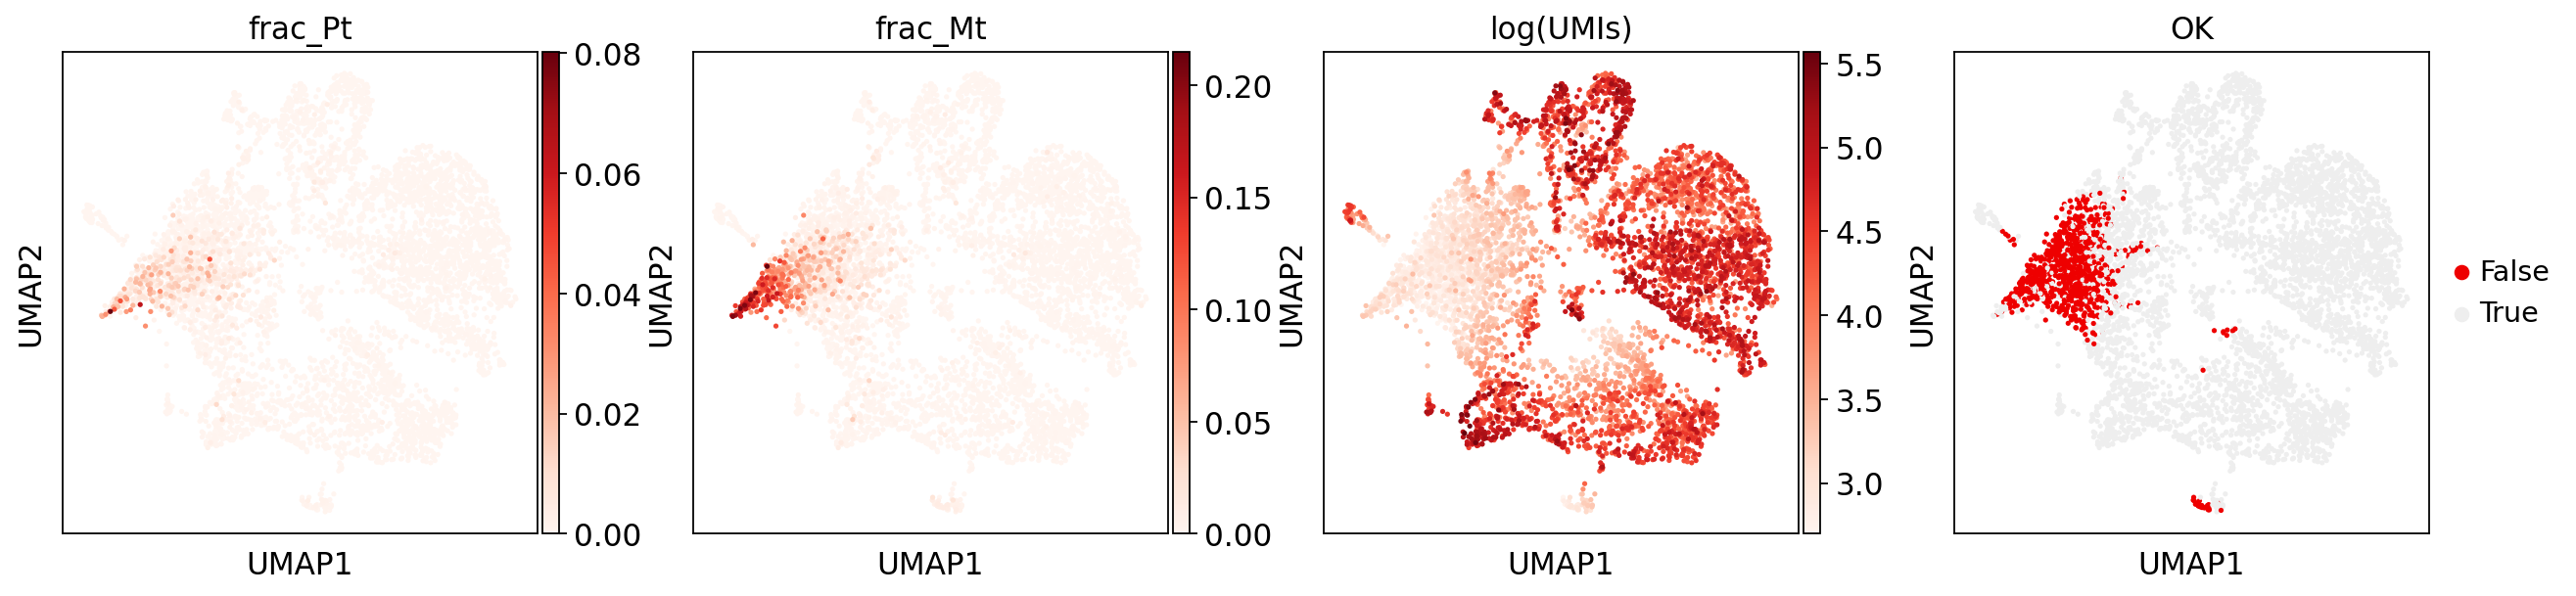

In [57]:
adata.obs['OK']  = (adata.obs['n_counts'] > 1000).astype('str')
adata.uns['OK_colors'] = ['#EE0000','#EEEEEE']
sc.pl.umap(adata, color=['frac_Pt','frac_Mt', 'log(UMIs)','OK'])

In [58]:
pd.crosstab(adata.obs['Cluster'], adata.obs['OK'])

OK       False  True
Cluster             
0          838   600
1            0  1024
2            7   530
3            0   535
4            0   520
5           10   408
6            0   347
7           29   111
8            0   123
9            2    97
10           0    53
11           0    52
12           0    49
13           6    42
14           0    21

Entropy is another way to represent how complex a cell's transcriptome is.  Dying cells can sometime retain a large amount of mitochondrial RNA, giving it a higher UMI count, but it is all a handful of artifactual genes, then who cares?

In [59]:
def entropy(array, r=1e-9):
    if isinstance(array, list):
        array = np.array(array)
    array = array + r
    total_counts = array.sum()
    pA = array / total_counts
    SE = -np.sum(pA*np.log2(pA))
    return SE

X = adata.layers['counts'].toarray()
axis = 1 # apply to axis: 0=genes, 1=cells
adata.obs['Entropy'] =np.apply_along_axis(entropy, axis, X)



/tmp/ipykernel_3960/543432672.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


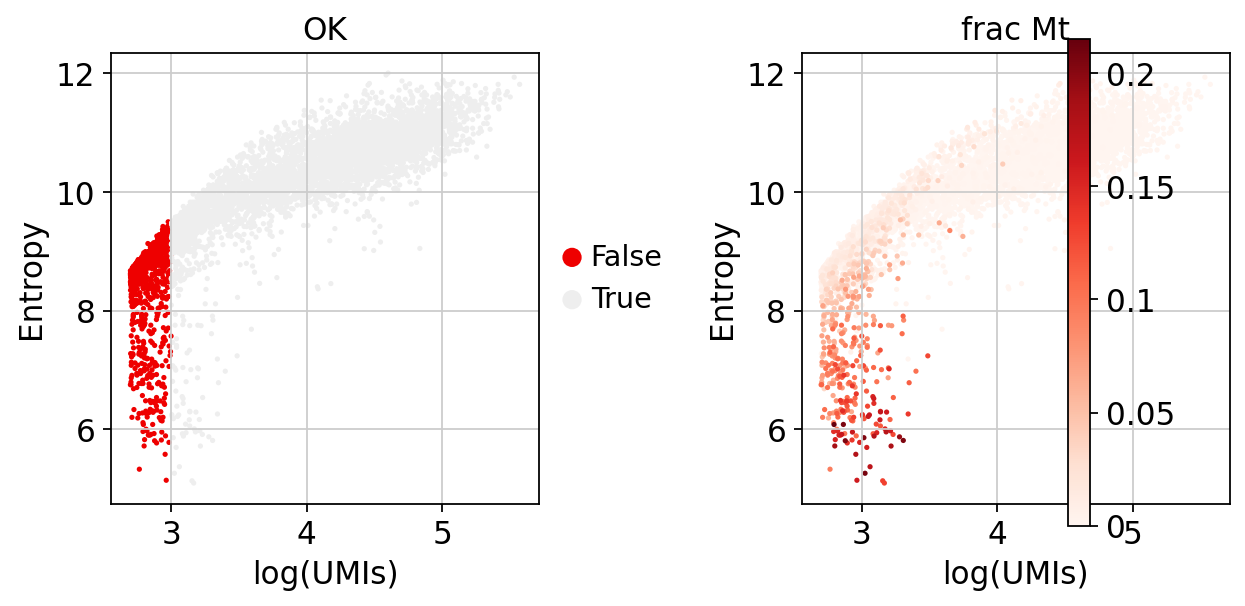

In [60]:
fig, ax = pl.subplots(1,2, figsize=[8,4])

sc.pl.scatter(adata, x='log(UMIs)', y='Entropy', color='OK', show=False, ax=ax[0])
sc.pl.scatter(adata, x='log(UMIs)', y='Entropy', color='frac_Mt', show=False, ax=ax[1])
pl.tight_layout()

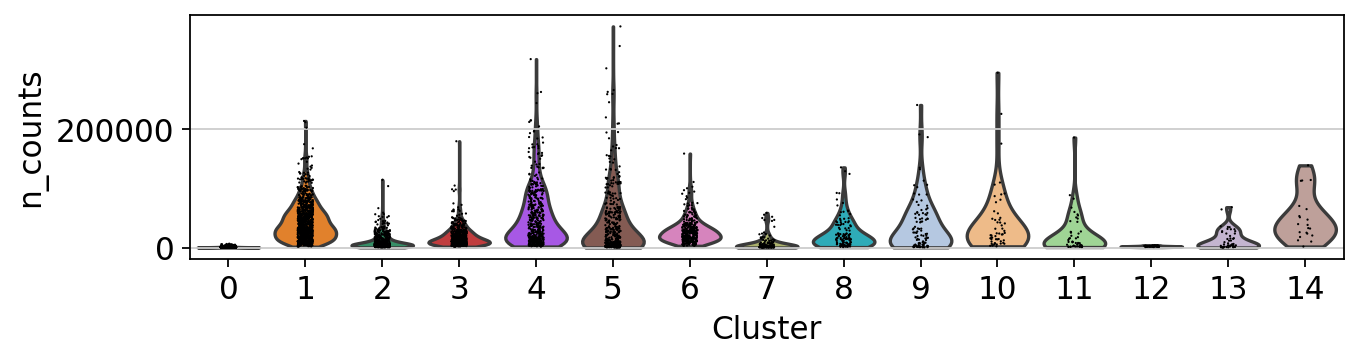

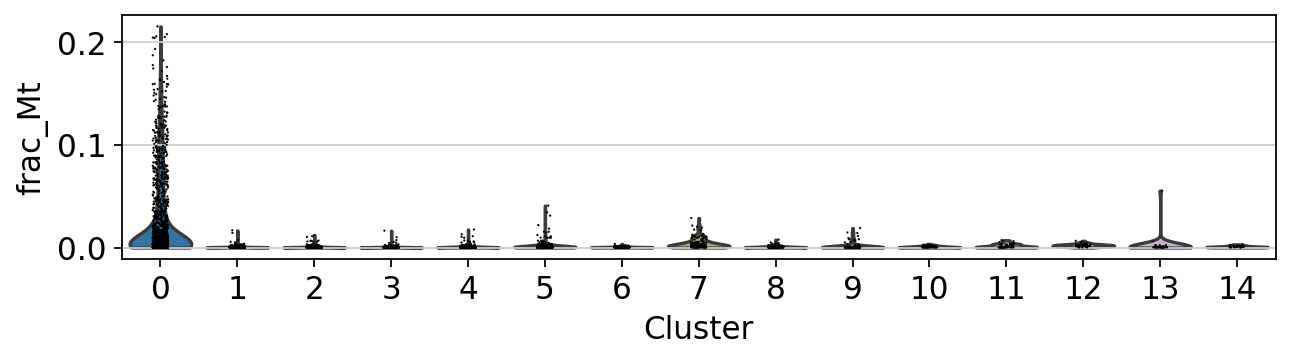

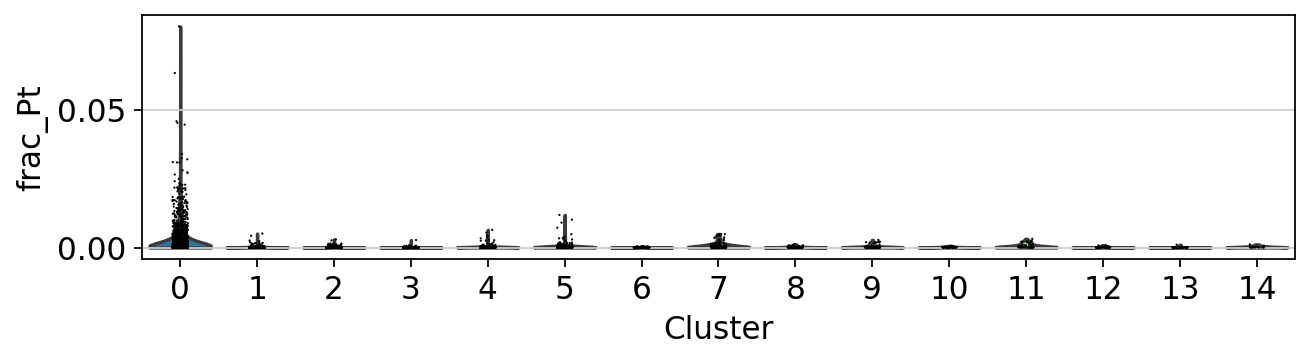

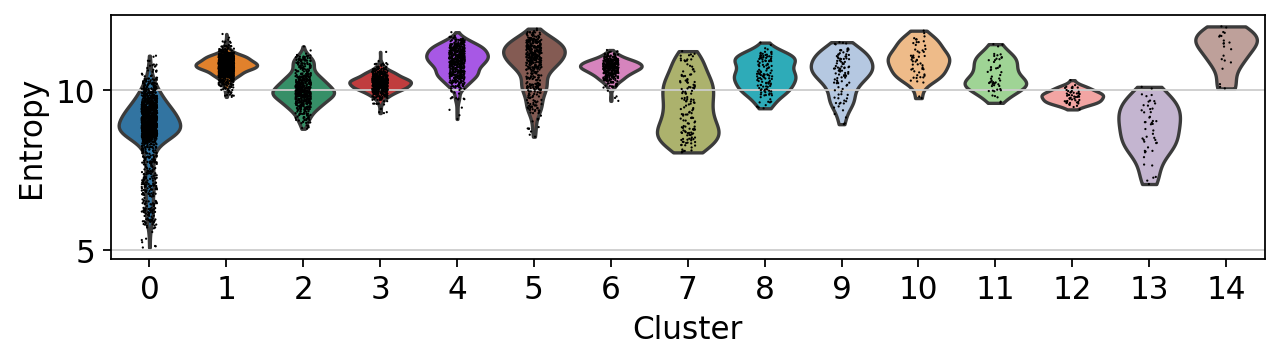

In [61]:
pl.rcParams['figure.figsize'] = [8,2]
sc.pl.violin(adata, groupby='Cluster', keys='n_counts')
sc.pl.violin(adata, groupby='Cluster', keys='frac_Mt')
sc.pl.violin(adata, groupby='Cluster', keys='frac_Pt')
sc.pl.violin(adata, groupby='Cluster', keys='Entropy')

pl.rcParams['figure.figsize'] = [4,4]

Sometimes the best method to filter cells is to use "guilt by association". Rather than drawing a hard cutoff based on one criterion, instead throw away entire cluster(s) filled with suspicious-looking cells. 

In [62]:
bdata = adata[adata.obs['Cluster'] != '0'].copy()

# alternatively, to discard more than one cluster:
# bdata = adata[adata.obs['Cluster'].isin(['0','8']).copy()

## Re-run the analysis on the filtered set

Combine all these steps into one quick function in case you want to do it over again quickly:

In [63]:
def redo_pca_cluster(
    adata: sc.AnnData,
    key_added: str = 'Subset_Cluster', 
    n_pcs: int = 50, 
    min_cells: int = 1, 
    cluster_resolution: float = 0.5, 
    n_top_genes: int = 4000, 
    exclude_highly_expressed: bool = True, 
    use_highly_variable: bool = True, 
    hvg_batch_key=None,
    scale: bool = True, 
    max_scale_value: int = 10, 
    n_neighbors: int=15,
    use_local: bool = False, 
    random_state: int = 0,
    ):
    
    print("Reclustering...")
    print("Using arguments:")
    print("n_pcs = ",n_pcs)
    #print("min_genes = ",min_genes)
    #print("min_counts = ",min_counts)
    print("min_cells = ",min_cells)
    print("cluster_resolution = ",cluster_resolution)
    print("n_top_genes = ",n_top_genes)
    print("use_highly_variable = ",use_highly_variable)
    
    print('Restoring raw counts from adata.layers[\'counts\']')
    adata.X = adata.layers['counts']

    sc.pp.normalize_total(
        adata, 
        target_sum=1e4, 
        exclude_highly_expressed=exclude_highly_expressed, 
        key_added='Norm_Factor')

    print ('Log transforming...')
    sc.pp.log1p(adata)
    print ('Saving normalized log-transformed data to .raw')
    adata.raw = adata.copy()
    print('Done.')
    
    if use_highly_variable:
        print("Computing Highly Variable Genes with n_top_genes = {}...".format(n_top_genes))
        sc.pp.highly_variable_genes(
            adata, 
            n_top_genes=n_top_genes, 
            batch_key=hvg_batch_key)

    else:
        if scale==True:
            print()
            print("Scaling .X layer to Z-scores with a max value of {}".format(max_scale_value))
            sc.pp.scale(adata, max_value=max_scale_value)

    print("PCA...")
    sc.pp.pca(adata, use_highly_variable=use_highly_variable, random_state=random_state)
    
    print("Computing KNN graph with n_pcs = {}...".format(n_pcs))
    sc.pp.neighbors(
        adata,
        n_pcs=n_pcs,
        n_neighbors=n_neighbors,
        random_state=random_state)

    #print("Computing UMAP...")
    sc.tl.umap(adata, random_state=random_state)
    
    print("Clustering by Leiden Modularity Optimization, cluster_resolution = {}...new clusters will be named: {}".format(cluster_resolution,key_added))
    sc.tl.leiden(adata,resolution=cluster_resolution, key_added=key_added, random_state=random_state)
    
    sc.pl.umap(adata, color=key_added)

Reclustering...
Using arguments:
n_pcs =  50
min_cells =  1
cluster_resolution =  0.5
n_top_genes =  4000
use_highly_variable =  True
Restoring raw counts from adata.layers['counts']
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GRMZM2G157845', 'GRMZM2G146502', 'GRMZM2G019039', 'GRMZM2G099496', 'GRMZM2G097316', 'GRMZM2G097340', 'GRMZM2G144653', 'GRMZM2G066111', 'GRMZM2G391286']
    finished (0:00:00)
Log transforming...
Saving normalized log-transformed data to .raw
Done.
Computing Highly Variable Genes with n_top_genes = 4000...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
PCA...
computing PCA
    on highly variable genes
    with n_comps=50
    finished (

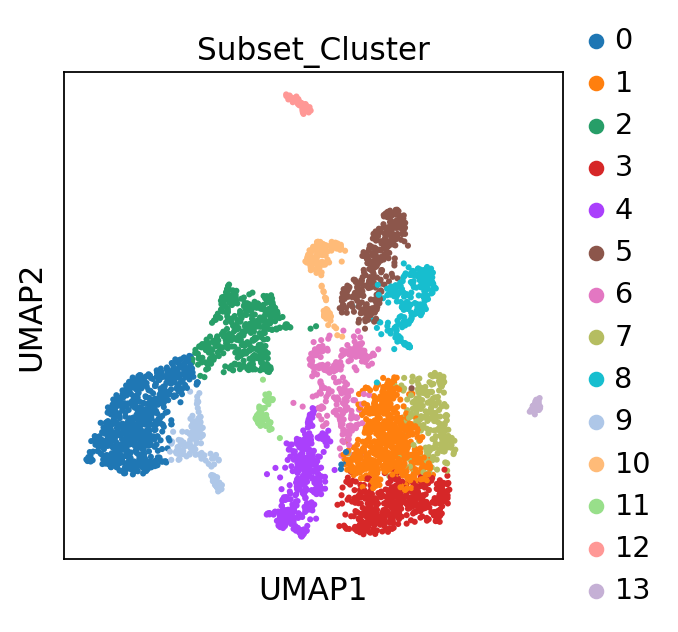

In [64]:
redo_pca_cluster(bdata)

## Batch correction with Harmony

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41592-019-0619-0/MediaObjects/41592_2019_619_Fig1_HTML.png?as=webp" align=left>  



<a href="https://www.nature.com/articles/s41592-019-0619-0"> Harmony paper by Korsunsky et al </a>

In [65]:
def harmony(adata, 
    batch_key='Sample', 
    theta: float = 4, #harmony docs use 2.0 as default 
    max_iter_harmony=15, 
    random_state=42,
    ridge_lambda: float = 1.0,
    sigma: float = 0.1,
    tau: int = 0,
    block_proportion: float = 0.05,
    n_clusters_harmony: int = None,
    use_gpu=False, 
    cluster_and_umap=True, 
    key_added='Cluster_harmony', 
    n_pcs=None,
    prune_graph=False):
    #requires pip install harmony-pytorch
    from harmony import harmonize
    
    if n_pcs:
        X = adata.obsm['X_pca'][:,:n_pcs]
    else: 
        X = adata.obsm['X_pca']
    print('Computing harmonized PCA using {} PCs...'.format(X.shape[1]))
    Z = harmonize(
        X,
        adata.obs,
        batch_key = batch_key,
        max_iter_harmony=max_iter_harmony,
        random_state=random_state,
        use_gpu=use_gpu,
        theta=theta,
        ridge_lambda=ridge_lambda,
        sigma=sigma,
        tau=tau,
        n_clusters=n_clusters_harmony,
        block_proportion = block_proportion,
    )
    adata.obsm['X_harmony'] = Z
    print('Storing harmonized PCA in adata.obsm[\'X_harmony\']')
    
    if cluster_and_umap:
        sc.pp.neighbors(adata, use_rep='X_harmony', random_state=random_state)
        sc.tl.umap(adata, random_state=random_state)
        sc.tl.leiden(adata, resolution=0.5, key_added=key_added, random_state=random_state)
        sc.pl.umap(adata, color=key_added)

In [68]:
bdata.obsm

AxisArrays with keys: X_pca, X_umap, X_harmony

Computing harmonized PCA using 50 PCs...
	Initialization is completed.
	Completed 1 / 15 iteration(s).
	Completed 2 / 15 iteration(s).
	Completed 3 / 15 iteration(s).
	Completed 4 / 15 iteration(s).
	Completed 5 / 15 iteration(s).
	Completed 6 / 15 iteration(s).
	Completed 7 / 15 iteration(s).
Reach convergence after 7 iteration(s).
Storing harmonized PCA in adata.obsm['X_harmony']
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 13 clusters and added
    'Cluster_harmony', the cluster labels (adata.obs, categorical) (0:00:00)


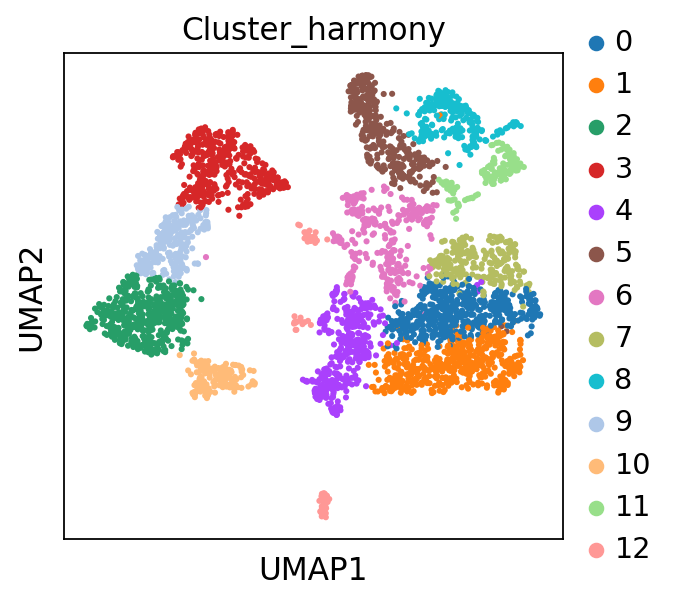

In [66]:
harmony(bdata, batch_key='Sample')

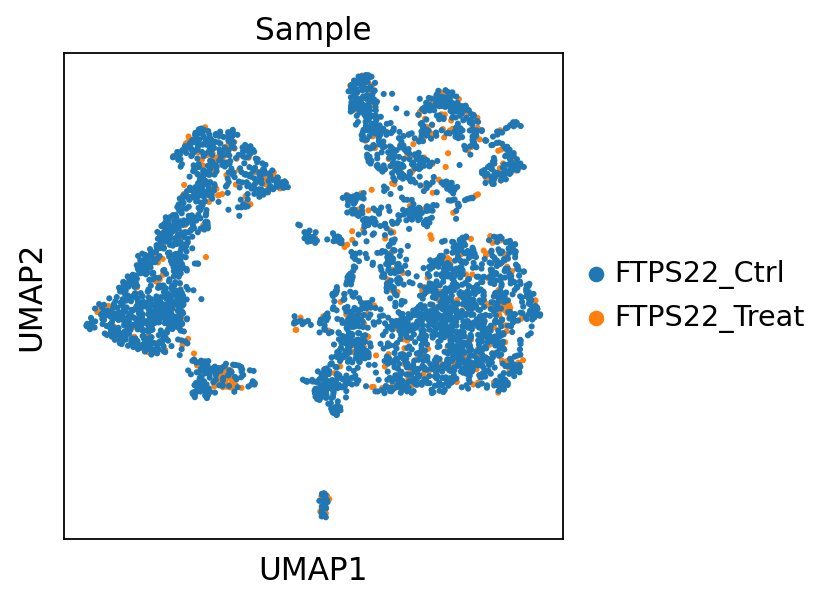

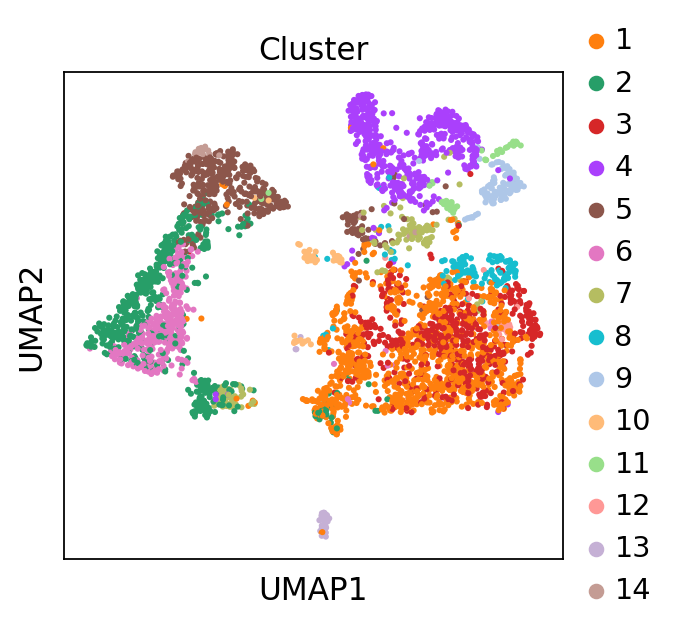

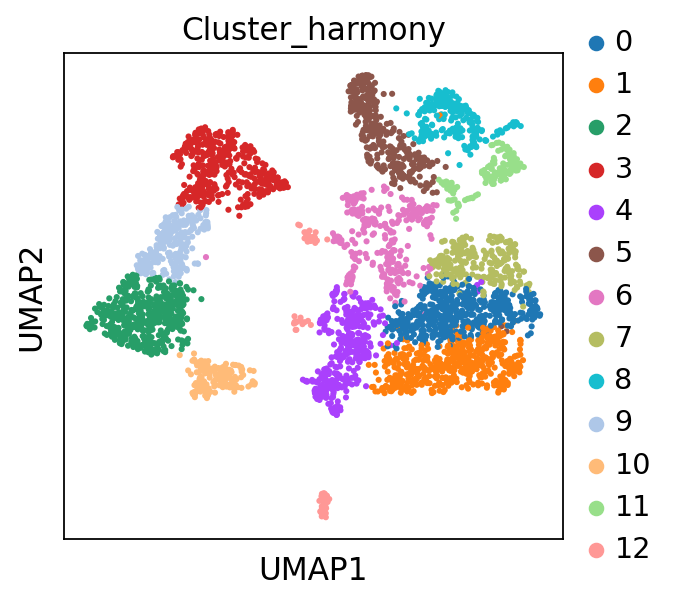

In [71]:
sc.pl.umap(bdata, color='Sample')
sc.pl.umap(bdata, color='Cluster')
sc.pl.umap(bdata, color='Cluster_harmony')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cluster_harmony']`


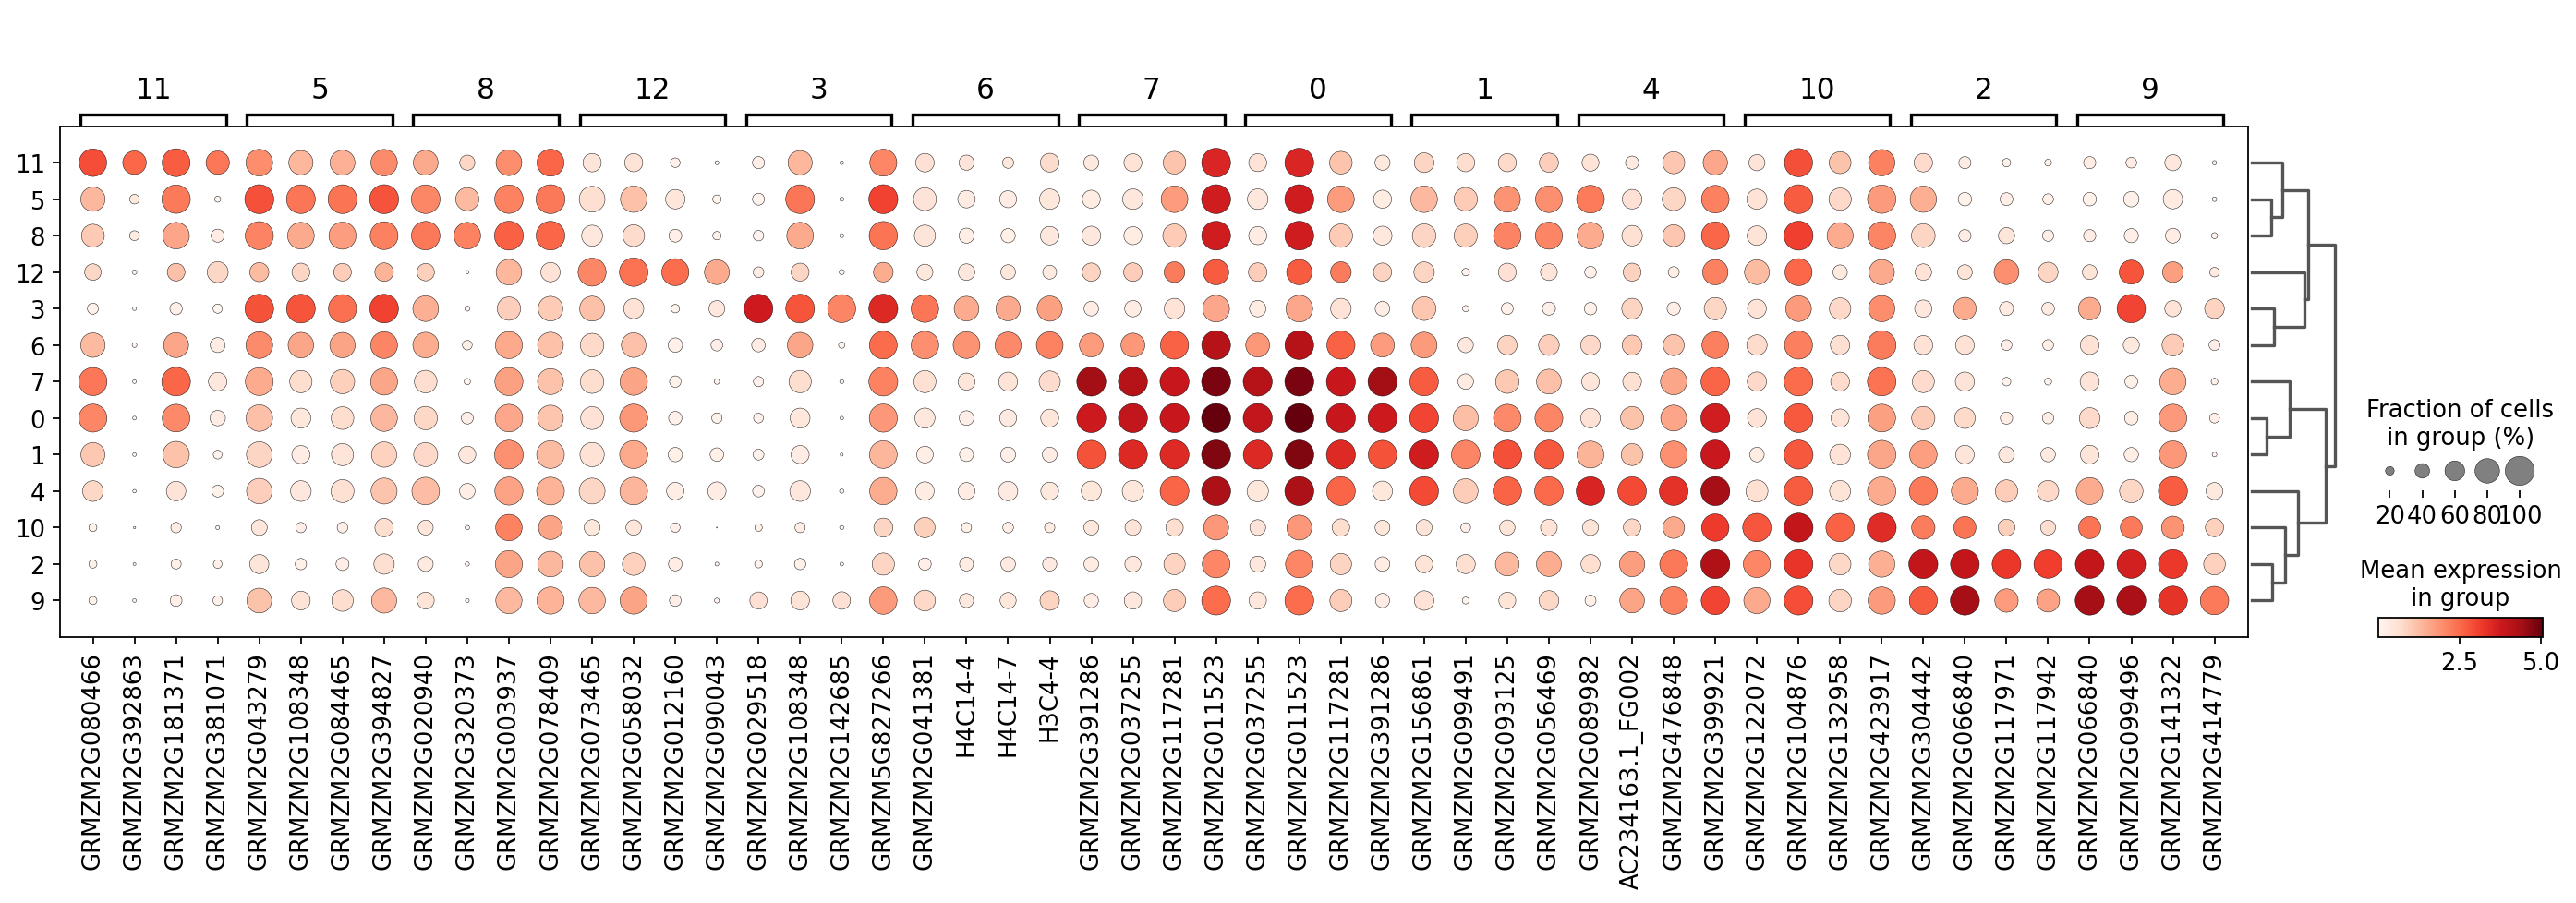

In [72]:
sc.tl.rank_genes_groups(bdata, groupby='Cluster_harmony')
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=4)

In [82]:
m

{'epidermis': ['GRMZM2G132509',
  'GRMZM2G143397',
  'GRMZM2G159344',
  'GRMZM2G144044',
  'GRMZM2G094990',
  'GRMZM2G066202',
  'GRMZM2G410916'],
 'cortex': ['GRMZM2G016836', 'GRMZM2G037255', 'GRMZM2G391272'],
 'Phloem': ['GRMZM2G123996',
  'GRMZM2G165638',
  'GRMZM2G081671',
  'GRMZM2G060522',
  'GRMZM2G158384',
  'GRMZM2G013970',
  'GRMZM2G349665',
  'GRMZM2G120069',
  'GRMZM2G010491',
  'GRMZM2G430394',
  'GRMZM2G134941',
  'GRMZM2G095411'],
 'xylem': ['GRMZM2G339943', 'GRMZM2G178998', 'GRMZM2G367701', 'GRMZM2G066326'],
 'stele': ['AC209819.3_FG005', 'GRMZM2G073770'],
 'pericycle': ['GRMZM2G338158'],
 'Columella': ['GRMZM2G046609', 'GRMZM2G012412', 'GRMZM2G146502'],
 'Endodermis': ['GRMZM2G112792', 'GRMZM2G074672', 'GRMZM2G097851'],
 'Endodermis initials': ['GRMZM2G065394', 'AC210669.3_FG001', 'GRMZM2G106276'],
 'QC': ['GRMZM2G180246', 'GRMZM2G014499']}

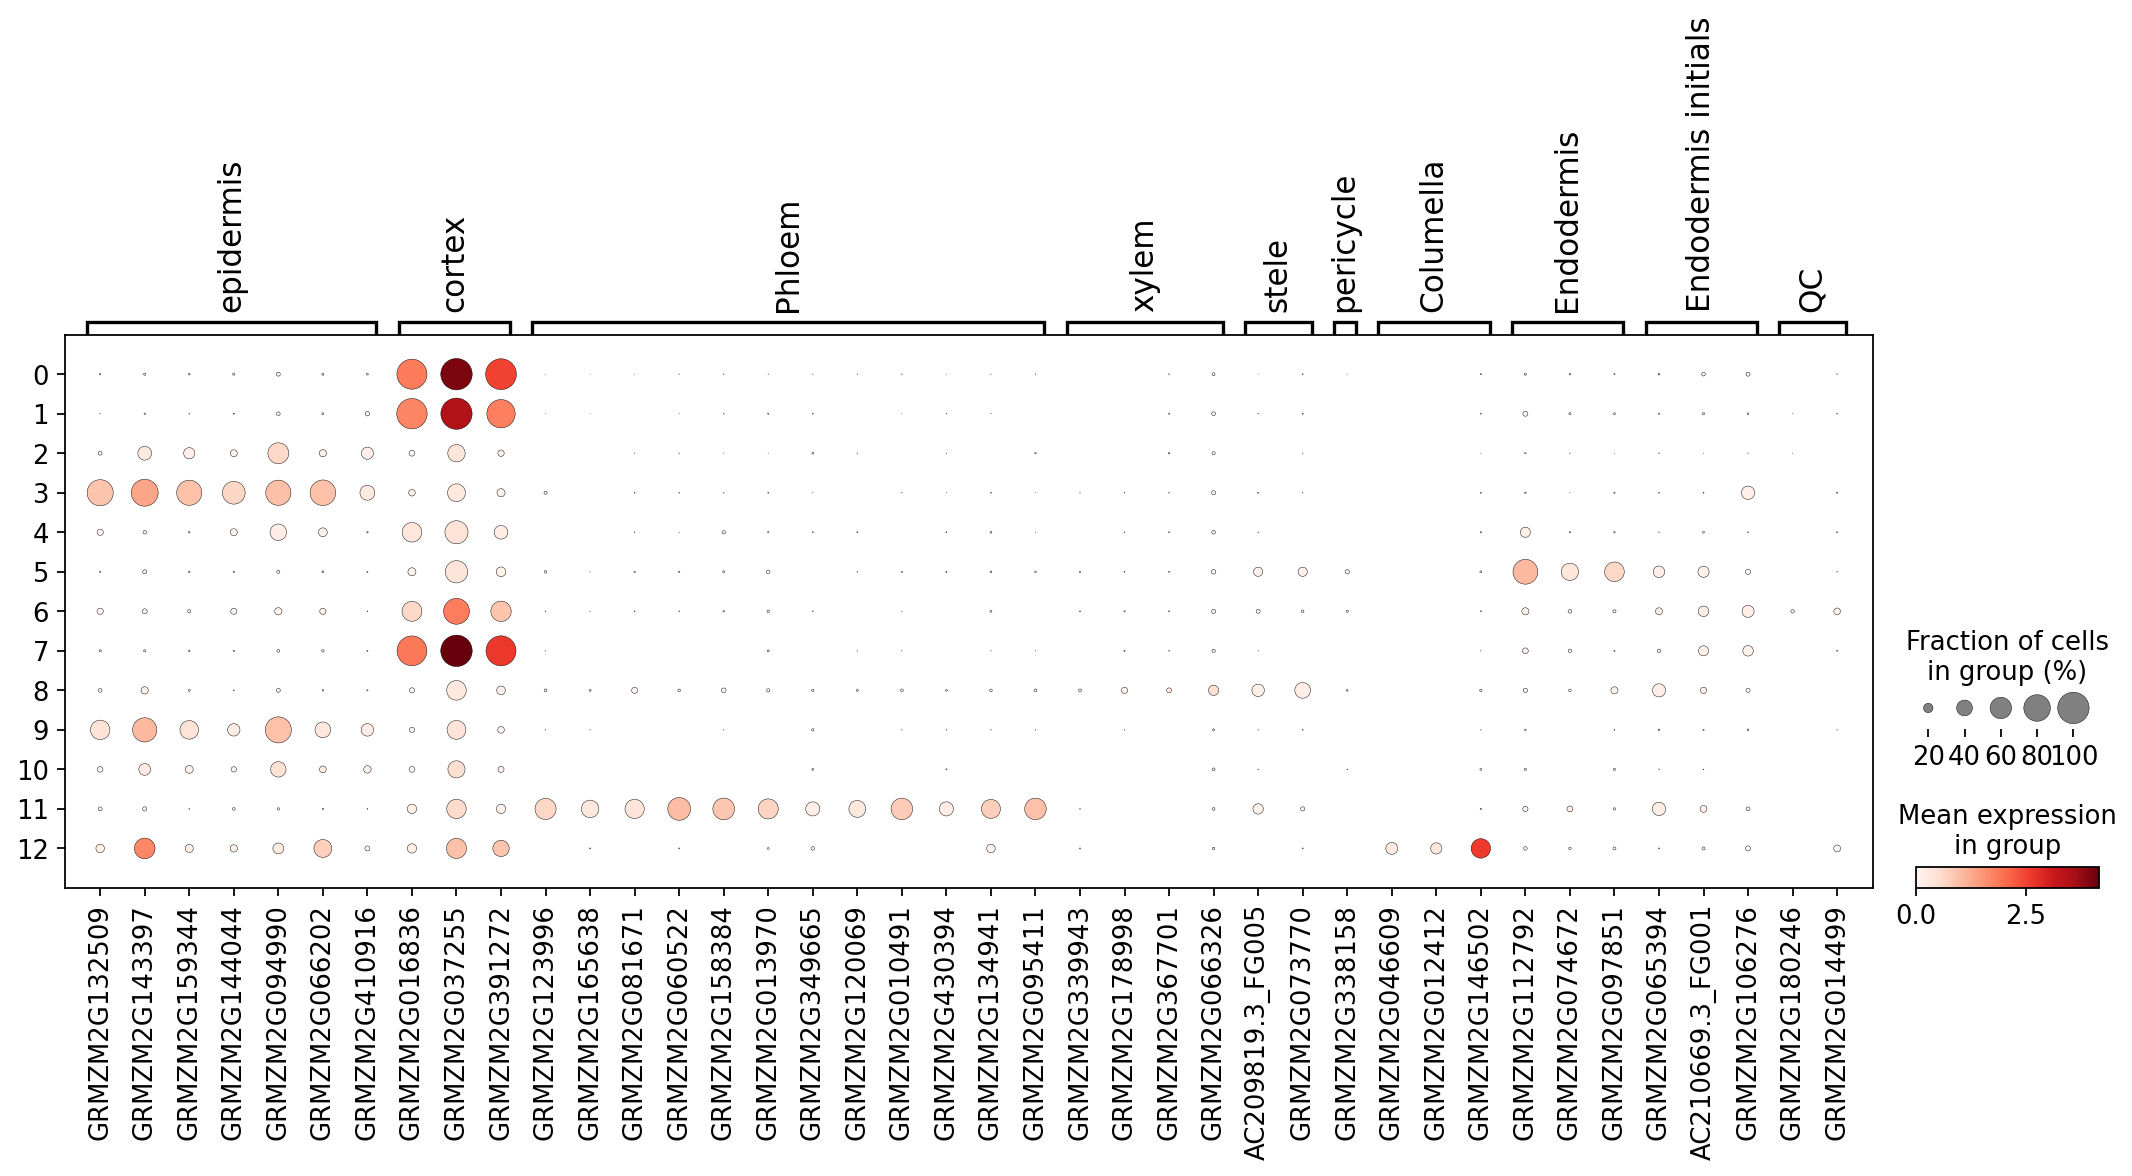

In [81]:

sheet_id = '1howUUTBDeF4T0XrvNXLzKk6qbZ-EvfT1KH3okgfJq4w'
sheet_name = 'Sheet1'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
markers = pd.read_csv(url)


m = {}
for c in markers["Cell_Type"].unique():
    genes = markers[markers['Cell_Type'] == c]['Gene_id'].tolist()
    genes = [name for name in genes if name in bdata.var_names]
    m[c] = genes
    
sc.pl.dotplot(bdata, groupby='Cluster_harmony', var_names=m)

computing score 'epidermis_score'
    finished: added
    'epidermis_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'cortex_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'cortex_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Phloem_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Phloem_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'xylem_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'xylem_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'stele_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'stele_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'pericycle_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'pericycle_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Columella_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Columella_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'Endodermis_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Endodermis_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'Endodermis initials_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Endodermis initials_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'QC_score'


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'QC_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


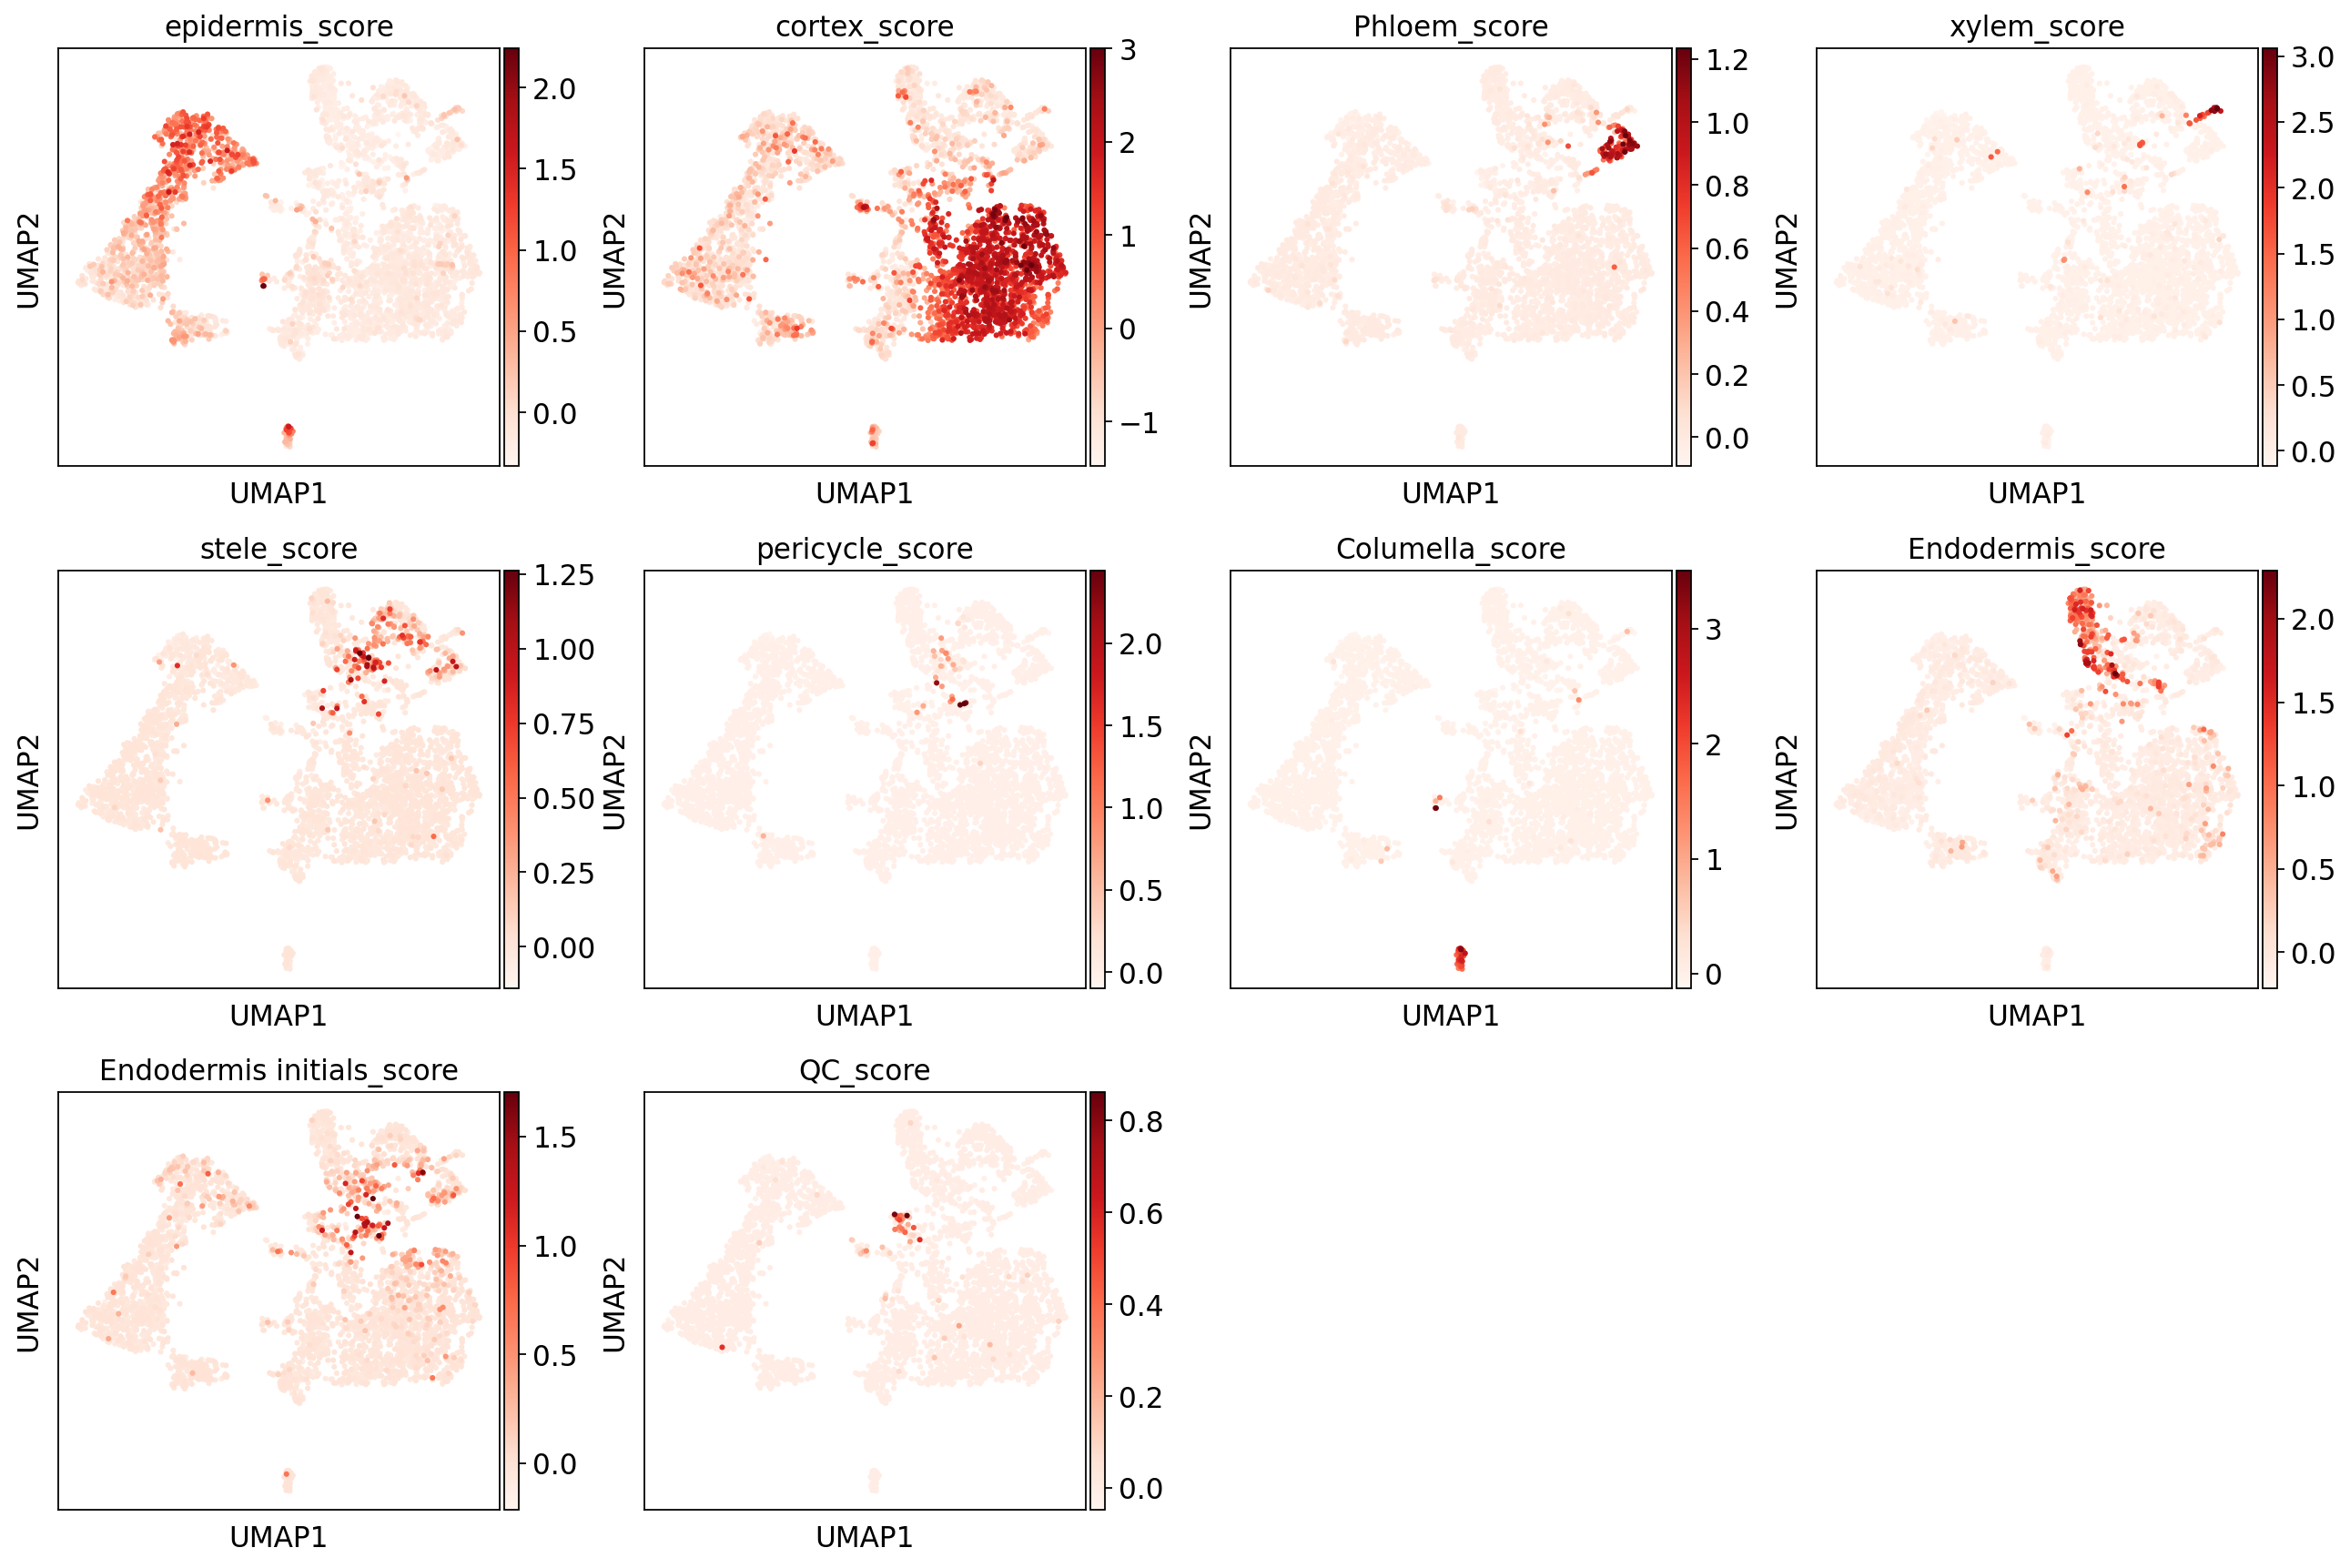

In [83]:
score_names = []
for i,gl in m.items():
    
    score_name = i + '_score'
    score_names += [score_name]
    sc.tl.score_genes(bdata, gene_list=gl, score_name=score_name)
    
sc.pl.umap(bdata, color=score_names)

# Write the processed data to a file

In [73]:
# The .X data layer is largely useless at this point, and takes up a lot of space
# It was used to generate the current clusters, but isn't used for diff.expression
# Before writing the file, get rid of it by filling it with a sparse matrix of zeros

cdata = bdata.copy()

from scipy import sparse

outfile = 'FTPS22_processed.h5ad'
cdata.X = sparse.csr_matrix(np.zeros(cdata.X.shape))
cdata.write(outfile, compression='gzip')
print(f'Wrote file: {outfile}, size: {os.path.getsize(outfile) / 2**20} MB')

del cdata

Wrote file: FTPS22_processed.h5ad, size: 125.17902278900146 MB


# Other exercises:

## Filtered vs Raw matrices

Cellranger outputs two data matrices. One 'raw' matrix, that contains gene expression counts for ALL possible barcodes, and one that has been filtered for the droplets that most liekly contained intact cells. Typically, people only bother starting with the filtered matrix, but there can be value in looking at the raw matrix.

For one, a sloppy cell filtering algorithm could systematically miss certain cell types with low mRNA counts, as was the case with early Cellranger (2.x) software. It would just completely gloss over T- and B- cells, or other transcriptionally "quiet" cells. 

You can also look at to gauge the amount of "ambient" RNA floating around in empty droplets.  Let's look at that here:

In [8]:
# See? Each data folder has a filtered and raw data matrix
glob.glob('data/count/FTPS22_Ctrl/outs/*h5')

['data/count/FTPS22_Ctrl/outs/raw_feature_bc_matrix.h5',
 'data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5']

**Where does that knee plot come from?**

That handy Cellranger knee plot lets you know where the cell calling algorithm drew its cutoffs to select the filtered cells.  It's simple enough to recreate, so for a quick exercise let's do that using Matplotlib.

reading data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5
 (0:00:01)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading data/count/FTPS22_Ctrl/outs/raw_feature_bc_matrix.h5
 (0:00:02)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


1812972 cells x 39483 genes


/tmp/ipykernel_9086/1426511103.py:31: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(list(range(len(df))))
/tmp/ipykernel_9086/1426511103.py:31: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(list(range(len(df))))


4399 cells x 39483 genes


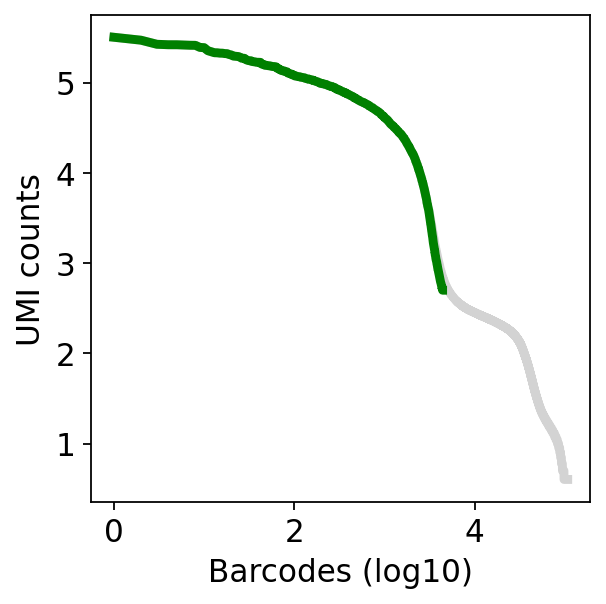

In [9]:
# Read in the filtered data from the Control sample
filt = sc.read_10x_h5('data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5')
filt.var_names_make_unique()

# Now read in the raw data
raw = sc.read_10x_h5('data/count/FTPS22_Ctrl/outs/raw_feature_bc_matrix.h5')
raw.var_names_make_unique()

# There are way too many barcodes in the raw data, most of which have only 1 or two counts
# Most of these are random sequencing noise.  So let's drop them out before visualizing

for n, data in enumerate([raw, filt]):
    colors = ['LightGrey','Green']
    
    print(f'{data.shape[0]} cells x {data.shape[1]} genes')
    
    # Calculate the number of UMIs per cell using Numpy
    data.obs['n_counts'] = np.sum(data.X, axis=1).A1.astype('int')
    
    #Calculate the number of unique genes per cell
    data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1.astype('int')
    
    # Filter out any barcodes with fewer than 4 UMIs
    data = data[data.obs['n_counts'] > 3]
    
    # Make a dataframe with UMI and gene counts, and sort them ascending
    df = data.obs.loc[:,['n_genes','n_counts']].sort_values(by='n_counts', ascending=False)
    
    # plot log(UMI counts) on y and log(rank order) on x
    y = np.log10(df['n_counts'])
    x = np.log10(list(range(len(df))))
    
    pl.plot(x,y, color=colors[n], linewidth=4)

pl.xlabel('Barcodes (log10)')
pl.ylabel('UMI counts')
pl.grid(None)


### Ambient RNA

When integrating samples, one of the most important sources of batch-related error is ambient RNA, or "soup". The raw data matrix gives you a chance to directly measure the abundance of ambient mRNAs in empty droplets to get an idea whether you might need an aggressive soup-based batch correction.  Let's compare our two samples for their ambient RNA content:

In [10]:
# Use glob to make a list containing both raw h5 files:
raw_h5s = glob.glob('data/count/*/outs/raw*h5')
raw_h5s

['data/count/FTPS22_Treat/outs/raw_feature_bc_matrix.h5',
 'data/count/FTPS22_Ctrl/outs/raw_feature_bc_matrix.h5']

**Plot the distribution of total UMI counts in ALL barcodes from each sample**

FTPS22_Treat
reading data/count/FTPS22_Treat/outs/raw_feature_bc_matrix.h5
 (0:00:01)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


FTPS22_Ctrl
reading data/count/FTPS22_Ctrl/outs/raw_feature_bc_matrix.h5


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


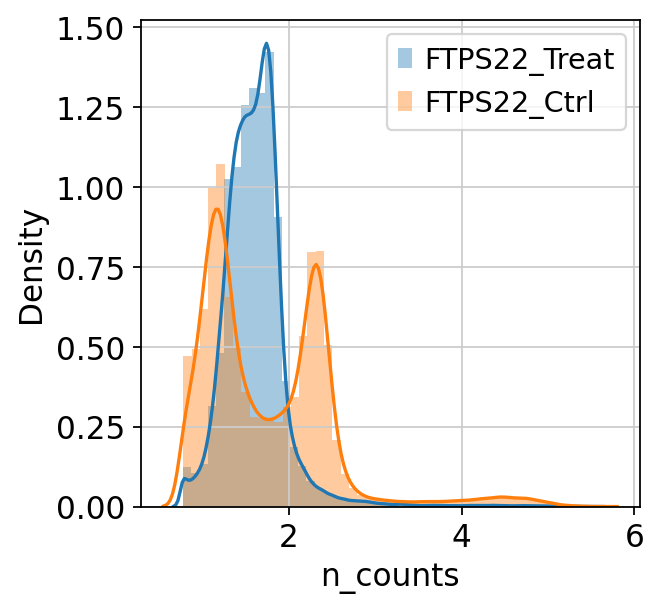

In [11]:
rawdata = {}

for h5 in raw_h5s:
    SAMPLE = h5.split('/')[-3]
    print(SAMPLE)
    
    data = sc.read_10x_h5(h5)
    
    data.obs['n_counts'] = np.sum(data.X, axis=1).A1.astype('int')
    data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1.astype('int')
    
    data = data[data.obs['n_counts'] > 5]
    
    soup_data = np.log10(data.obs['n_counts'])
    
    # Plot using seaborn distplot, which handily makes a histogram and KDE overlay and plots with matplotlib
    sns.distplot(soup_data, label=SAMPLE)
    
    # Stash this raw data in a dictionary for use in a second
    rawdata[SAMPLE] = data.copy()
    
pl.legend()

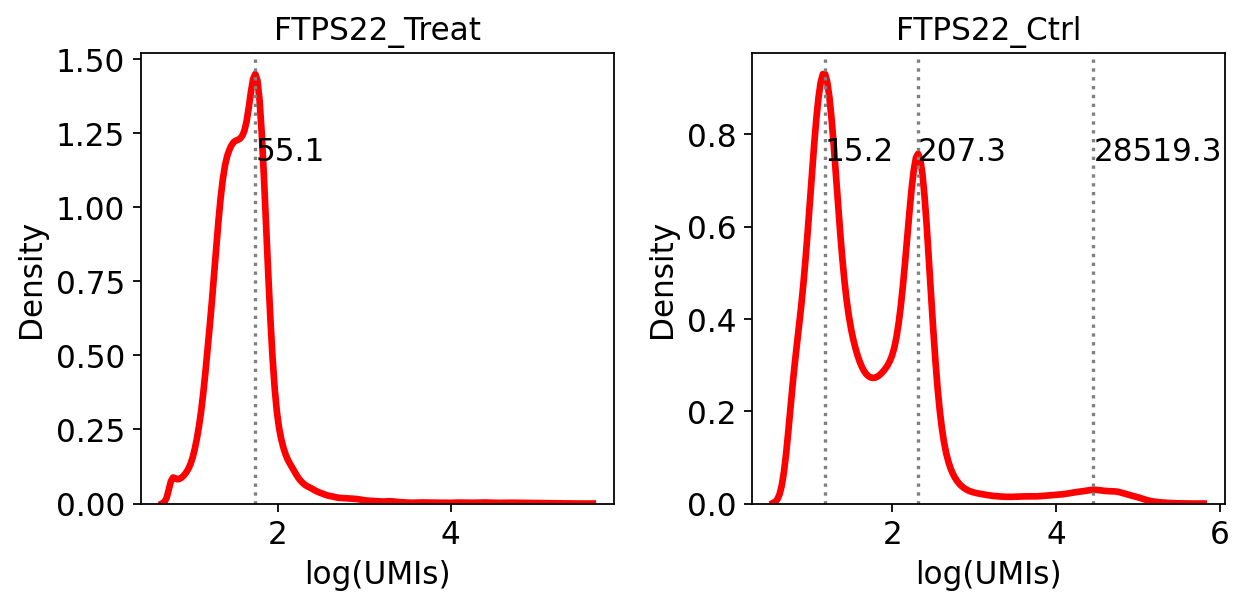

In [12]:
from scipy.signal import find_peaks

fig, ax = pl.subplots(1,2,figsize=[8,4])

for num, sample in enumerate(rawdata.keys()):
    
    data = np.log10(rawdata[sample].obs['n_counts'])
    ax[num] = sns.kdeplot(data, color='Red', linewidth=3, ax=ax[num])

    x = ax[num].lines[0].get_xdata() # Get the x data of the distribution
    y = ax[num].lines[0].get_ydata() # Get the y data of the distribution
    #peaks = scipy.signal.find_peaks(y, width=10)[0]
    peaks = find_peaks(y, width=10)[0]
    peak_logUMIs = x[peaks]
    peaks_delog = np.round(10**peak_logUMIs.astype('float'),1)

    for n,peak in enumerate(peak_logUMIs):
        ax[num].axvline(peak, linestyle=':', color='grey')
        ax[num].text(x=peak, y= y.max() * 0.8, s=peaks_delog[n])
        ax[num].set_title(sample)
    ax[num].grid(None)
    ax[num].set_xlabel('log(UMIs)')
    
pl.tight_layout()

Interesting.  While the vast majority of the Treated droplets contain about 55 ambient UMI counts, the Control sample is bimodal.  Half contain ~15 UMIs, while the other half contain ~200 UMIs.  Meanwhile, the cell-containing droplets have ~28K UMIs. There might be reason to run some kind of ambient RNA correction tool here, like *SoupX, decontX, or cellbender*, but that will be for another day.

### Reading from .mtx format

In [109]:
# Cellranger's output folder in MTX format:
! ls 'data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix'

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


If these files are coming straight out of Cellranger, Scanpy can read a whole directory in natively:


In [110]:
example = sc.read_10x_mtx('data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


... storing 'feature_types' as categorical


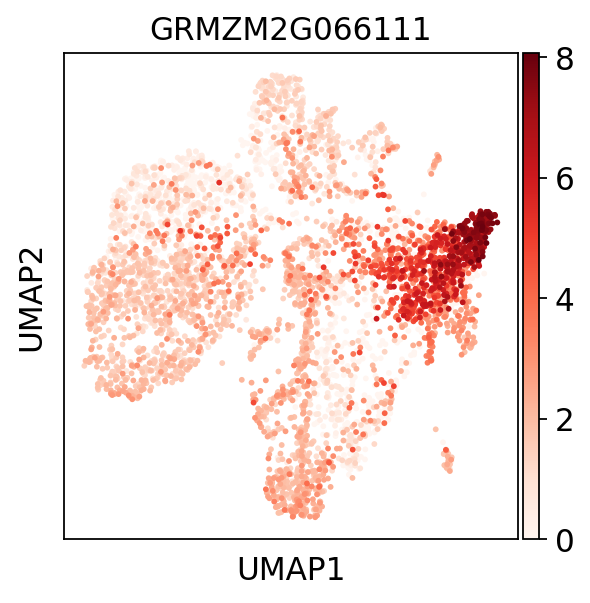

In [159]:
preprocess(example)
reduce_dimensions(example)
sc.pp.neighbors(example)
sc.tl.umap(example)
sc.pl.umap(example, color='GRMZM2G066111')

## Import data from GEO

Rule # 383: Every public dataset you ever download will be in some different random format.

This one is in a pretty clean .csv file, though:

Ortiz-Ramírez C, Guillotin B, Xu X, Rahni R et al. **Ground tissue circuitry regulates organ complexity in maize and <i>Setaria</i>**. Science 2021 Dec 3;374(6572):1247-1252. PMID: 34855479


https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE173087

In [137]:
countdata = pd.read_table('birnbaum/GSE173087_Maize_rootsc_counts.txt.gz', index_col=0)

In [140]:
countdata[:3]

Geneid              Zm00001d027230  Zm00001d027231  Zm00001d027236  \
AAACCTGAGAGCTTCT_1               0               1               0   
AAACCTGAGTGATCGG_1               0               0               0   
AAACCTGCACTGTCGG_1               0               0               0   

Geneid              Zm00001d027239  Zm00001d027240  Zm00001d027242  \
AAACCTGAGAGCTTCT_1               0               0               0   
AAACCTGAGTGATCGG_1               0               0               0   
AAACCTGCACTGTCGG_1               0               0               0   

Geneid              Zm00001d027256  Zm00001d027257  Zm00001d027258  \
AAACCTGAGAGCTTCT_1               0               0               0   
AAACCTGAGTGATCGG_1               0               0               0   
AAACCTGCACTGTCGG_1               0               0               0   

Geneid              Zm00001d027259  ...  Zm00001d025154  Zm00001d025365  \
AAACCTGAGAGCTTCT_1               0  ...               0               0   
AAACCTGAGTGATCGG_1               0  ...               0               0   
AAACCTGCACTGTCGG_1               0  ...               0               0   

Geneid              Zm00001d025625  Zm00001d025884  Zm00001d026071  \
AAACCTGAGAGCTTCT_1               0               0               0   
AAACCTGAGTGATCGG_1               0               0               0   
AAACCTGCACTGTCGG_1               0               0               0   

Geneid              Zm00001d026149  Zm00001d023190  Zm00001d026375  \
AAACCTGAGAGCTTCT_1               0               0               0   
AAACCTGAGTGATCGG_1               0               0               0   
AAACCTGCACTGTCGG_1               0               0               0   

Geneid              Zm00001d026492  Zm00001d000254  
AAACCTGAGAGCTTCT_1               0               0  
AAACCTGAGTGATCGG_1               0               0  
AAACCTGCACTGTCGG_1               0               0  

[3 rows x 27533 columns]

In [139]:
# Note that we need to swap rows and columns to be able to import annotations
countdata = countdata.T

/tmp/ipykernel_9086/1586680416.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  bbdata = sc.AnnData(countdata)


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Zm00001d031168', 'Zm00001d040029', 'Zm00001d041984', 'Zm00001d041985', 'Zm00001d019034', 'Zm00001d012561', 'Zm00001d047117']
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


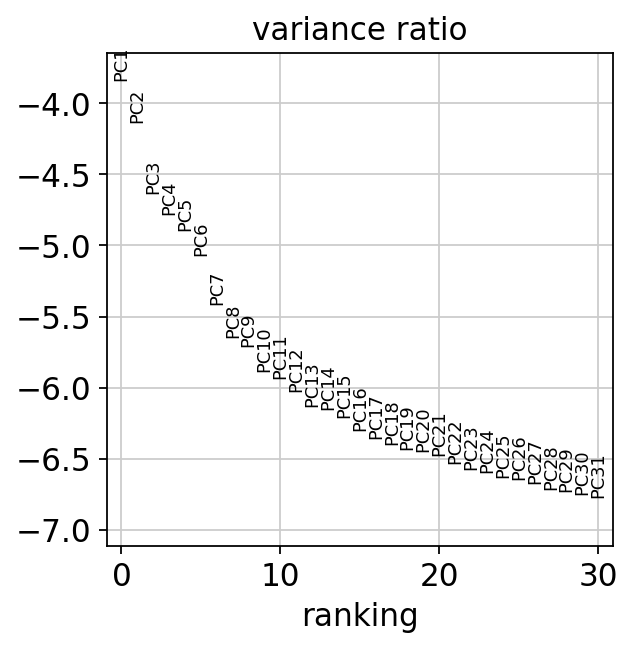

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


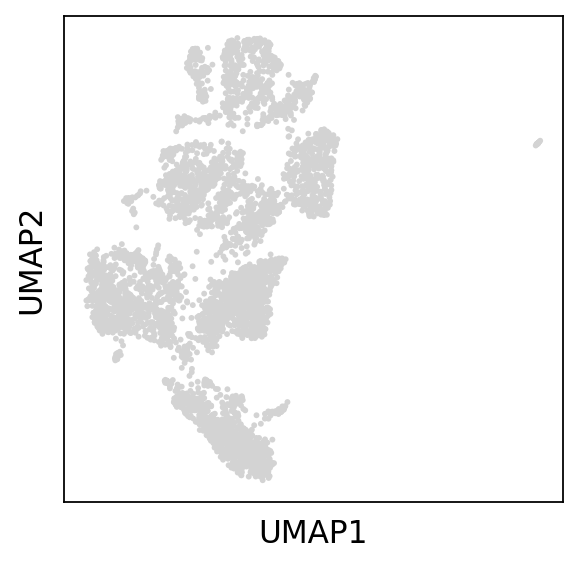

In [141]:
bbdata = sc.AnnData(countdata)
bbdata.X = scipy.sparse.csr_matrix(bbdata.X.astype('int'))

preprocess(bbdata)
reduce_dimensions(bbdata)

sc.pp.neighbors(bbdata)
sc.tl.umap(bbdata)
sc.pl.umap(bbdata)

### Import coordinates from Cellranger

In [154]:
path = 'data/count/FTPS22_Ctrl/outs/'
ctrl = sc.read_10x_h5(path + 'filtered_feature_bc_matrix.h5')

preprocess(ctrl)
umap = pd.read_csv('data/count/FTPS22_Ctrl/outs/analysis/tsne/2_components/projection.csv', index_col=0)

ctrl.obsm['X_umap'] = umap.values

reading data/count/FTPS22_Ctrl/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/exouser/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GRMZM2G314328', 'GRMZM2G157845', 'GRMZM2G146502', 'GRMZM2G019039', 'GRMZM2G099496', 'GRMZM2G097316', 'GRMZM2G097340', 'GRMZM2G144653', 'GRMZM2G329636', 'GRMZM2G066111', 'GRMZM2G442129', 'GRMZM5G834666', 'GRMZM2G054501']
    finished (0:00:00)


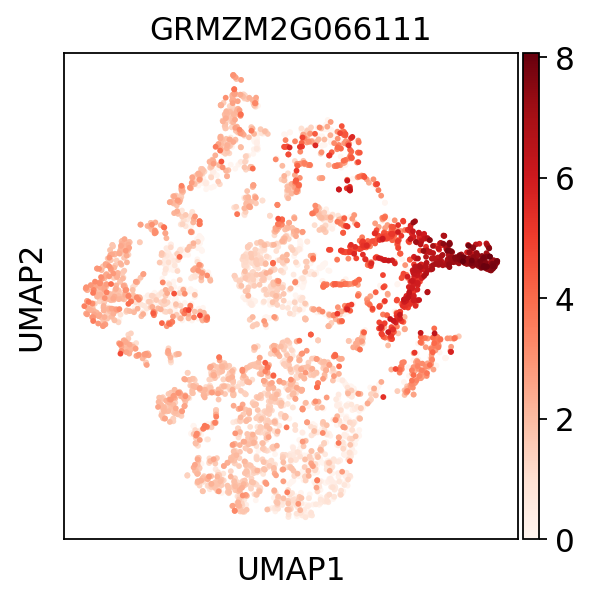

In [157]:
sc.pl.umap(ctrl, color='GRMZM2G066111')